In [92]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import geopandas as gpd

import requests
from bs4 import BeautifulSoup

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 200

# import yaml
from paths import *
from scripts import manipulation
from scripts import io
from scripts import vis_graphs

import unidecode
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
from scripts import vis_layout

## Manipulate Data from SEADE

In [37]:
#load variables and geocodes
var, geocode_seade = io.load_variables_geocodes()

#load KPIs, last kpi and historic
df_last, dh_history = io.load_kpis()

#merge the variables and geocodes with KPIs
dd = manipulation.merge_data(df_last, var, geocode_seade)

#load shapefiles
sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
sp = sp[['geocodigo','geometry']]

In [38]:
dd.head()

localidade                           variavel             unidade  \
0           Aparecida  Concluintes do Ensino Fundamental  Não possui unidade   
1              Areias  Concluintes do Ensino Fundamental  Não possui unidade   
2             Bananal  Concluintes do Ensino Fundamental  Não possui unidade   
3            Caçapava  Concluintes do Ensino Fundamental  Não possui unidade   
4  Cachoeira Paulista  Concluintes do Ensino Fundamental  Não possui unidade   

               periodo   ano  valor      tipo  portal  geocodigo  
0  2001-2005/2007-2013  2013    589  educacao     1.0  3502507.0  
1  2001-2005/2007-2013  2013     66  educacao     1.0  3503505.0  
2  2001-2005/2007-2013  2013    143  educacao     1.0  3504909.0  
3  2001-2005/2007-2013  2013   1374  educacao     1.0  3508504.0  
4  2001-2005/2007-2013  2013    430  educacao     1.0  3508603.0

## Educacao
 - [QEdu](https://www.qedu.org.br/) 
 - [Dados Abertos da Educação de SP](https://dados.educacao.sp.gov.br/search/type/dataset)
 - [INEP - Microdados](http://portal.inep.gov.br/microdados#)
 - [IDEB](http://portal.inep.gov.br/web/guest/educacao-basica/ideb/resultados)
 - [Censo Escolar - BI](https://inepdata.inep.gov.br/analytics/saw.dll?Portal&PortalPath=%2Fshared%2FEduca%C3%A7%C3%A3o%20B%C3%A1sica%20-%20Acesso%20Externo%2FArquivos%2FCenso%2FConsolidado%2FInforma%C3%A7%C3%B5es%20Consolidadas%2FFun%C3%A7%C3%B5es%20Docentes%2FPanorama%20deFun%C3%A7%C3%B5es%20Docentes%20na%20Educa%C3%A7%C3%A3o%20B%C3%A1sica)



In [164]:
mask = dd['localidade']=='Taubaté'
variables = dd[mask]['variavel'].tolist()

In [136]:
def plot_barss(df, var,themes ,xx='localidade', yy='valor'):
    
    mask = (df['variavel']==var) & (df['valor']!=' ') 
    # mask = (dd['portal']==1)
    df = df[mask]
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    
    df = df.sort_values(by='valor')

    mask  = (df['valor'].isnull()) | (df['localidade'].isin(['Vale do Paraíba e Litoral Norte','Estado de São Paulo']))
    vale_value = round(df[np.logical_not(mask)]['valor'].mean(),2)

    if len(df[df['localidade'] == 'Vale do Paraíba e Litoral Norte'])==0:
        df_vale = df.head(1)
        df_vale['localidade'] = 'Vale do Paraíba e Litoral Norte'
        df_vale['valor'] = vale_value
    else:

        df.loc[df['localidade'] == 'Vale do Paraíba e Litoral Norte', ['valor']] = vale_value

    df = df.fillna(0)
    df = df.sort_values(by='valor')

    sp_color = '#0D485A'
    vale_color  = '#FA7609'
    
    
    df['color'] = np.where((df['localidade']=='Estado de São Paulo') | (df['localidade']=='Vale do Paraíba e Litoral Norte'), sp_color,vale_color)
    
    trace = go.Bar(
                    y=df[xx],
                    x=df[yy],
                    marker_color=df['color'],
                    orientation='h'
            )
    
    data = [trace]
    
    ano = max(df['ano'])
    
    title = f'{var} - {ano}'
    
    layout = vis_layout.get_layout(themes,title)
    
    
    
    fig = go.Figure(data=data, layout=layout)
    


        
        

    
    return fig, df

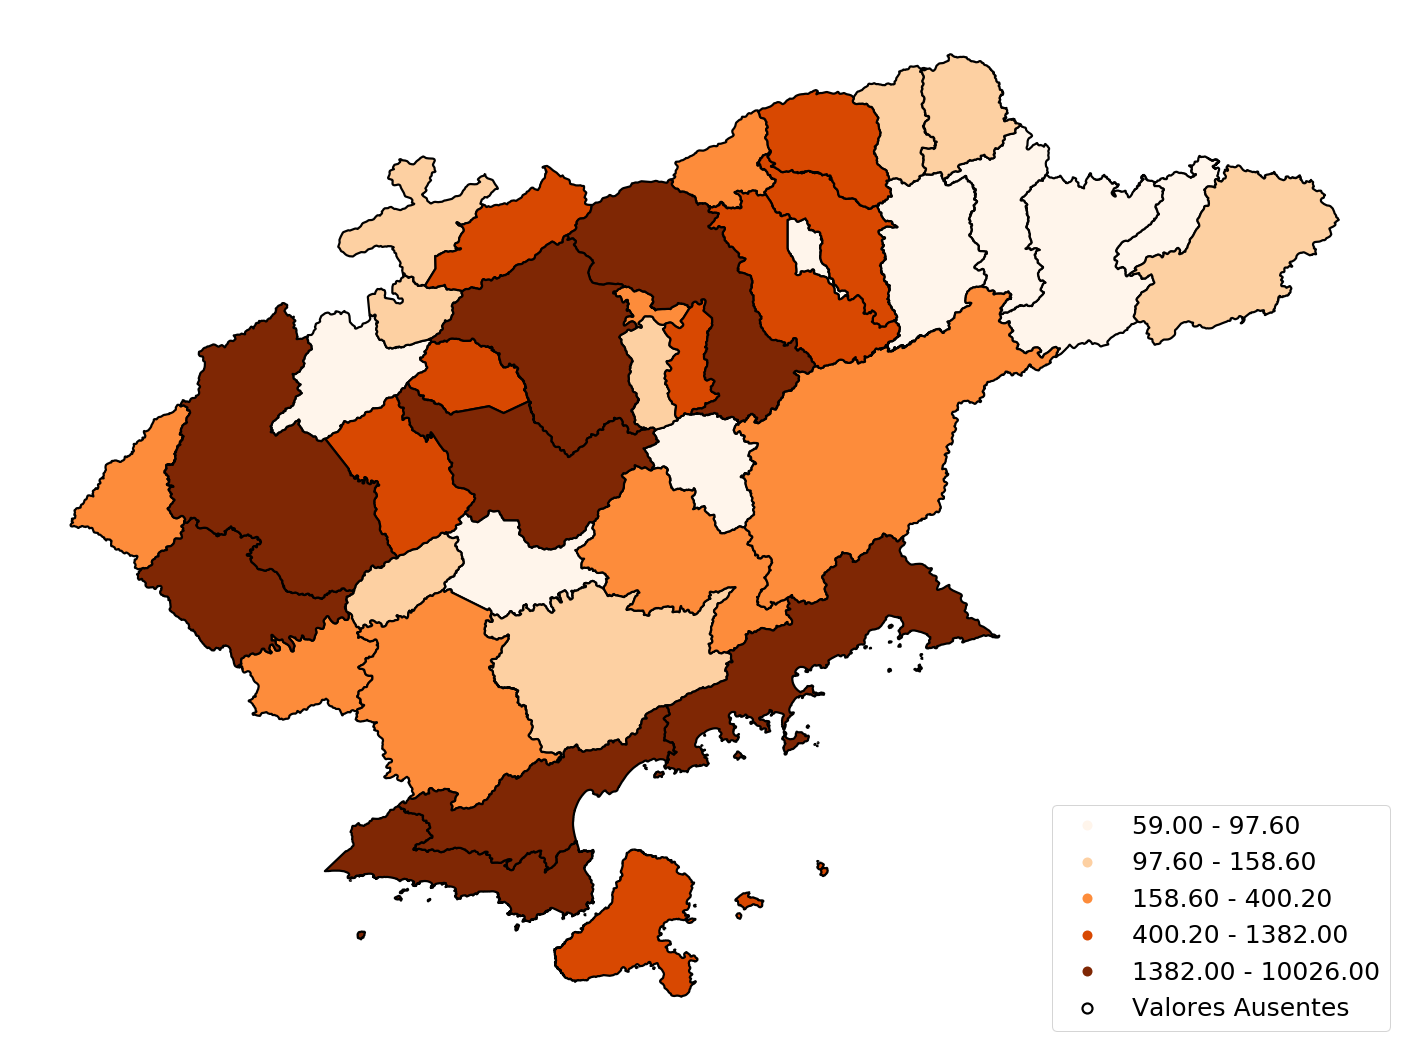

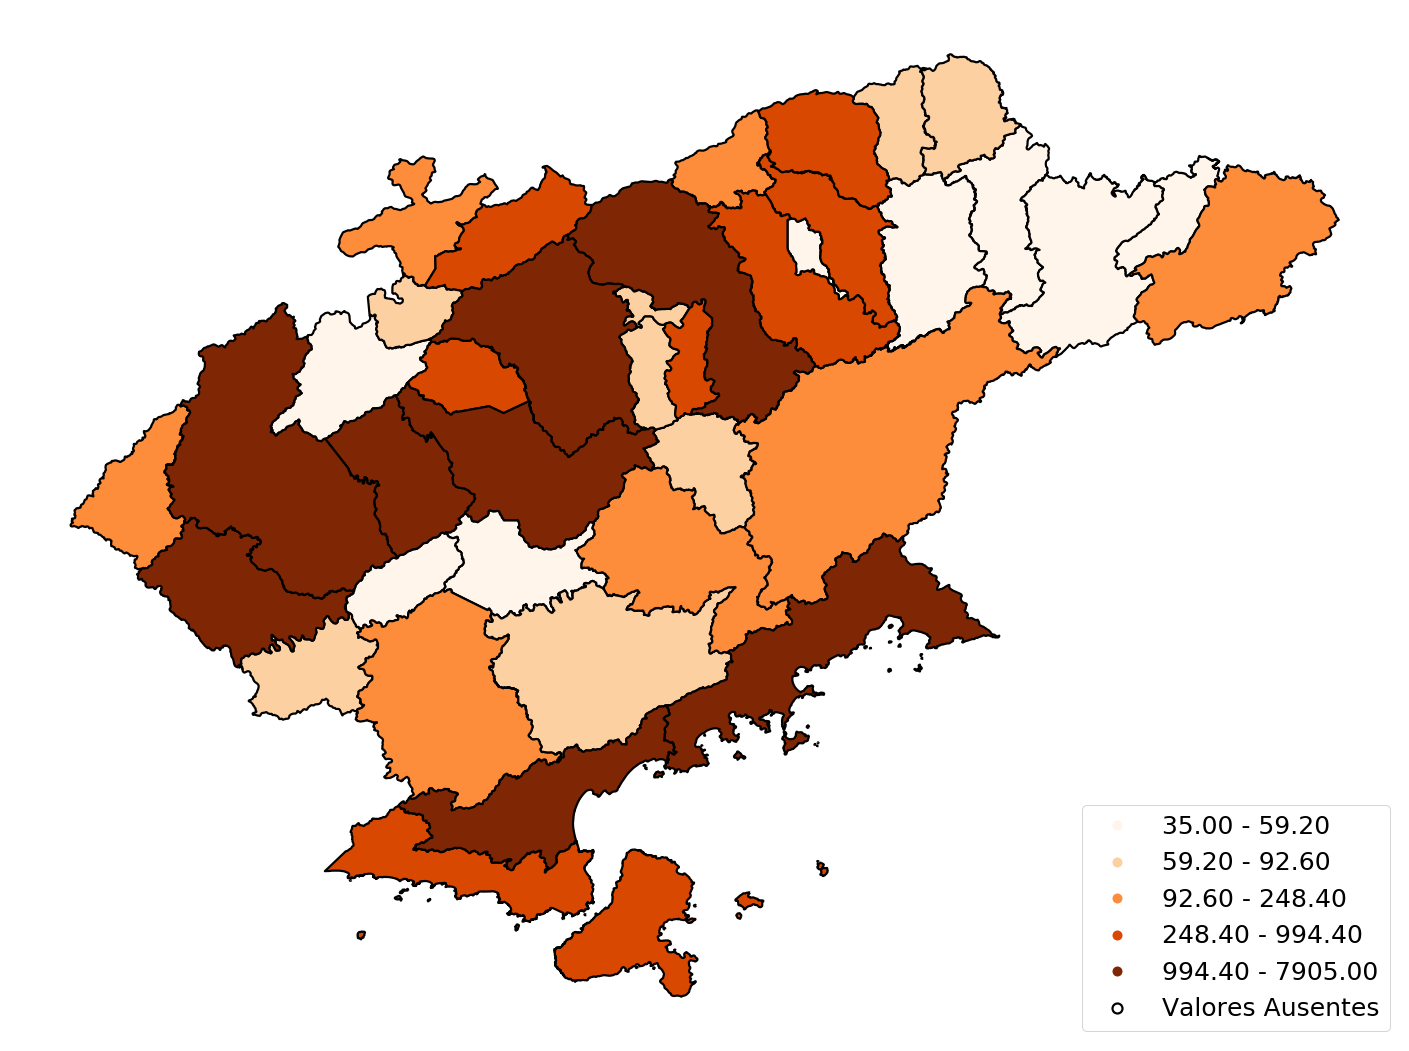

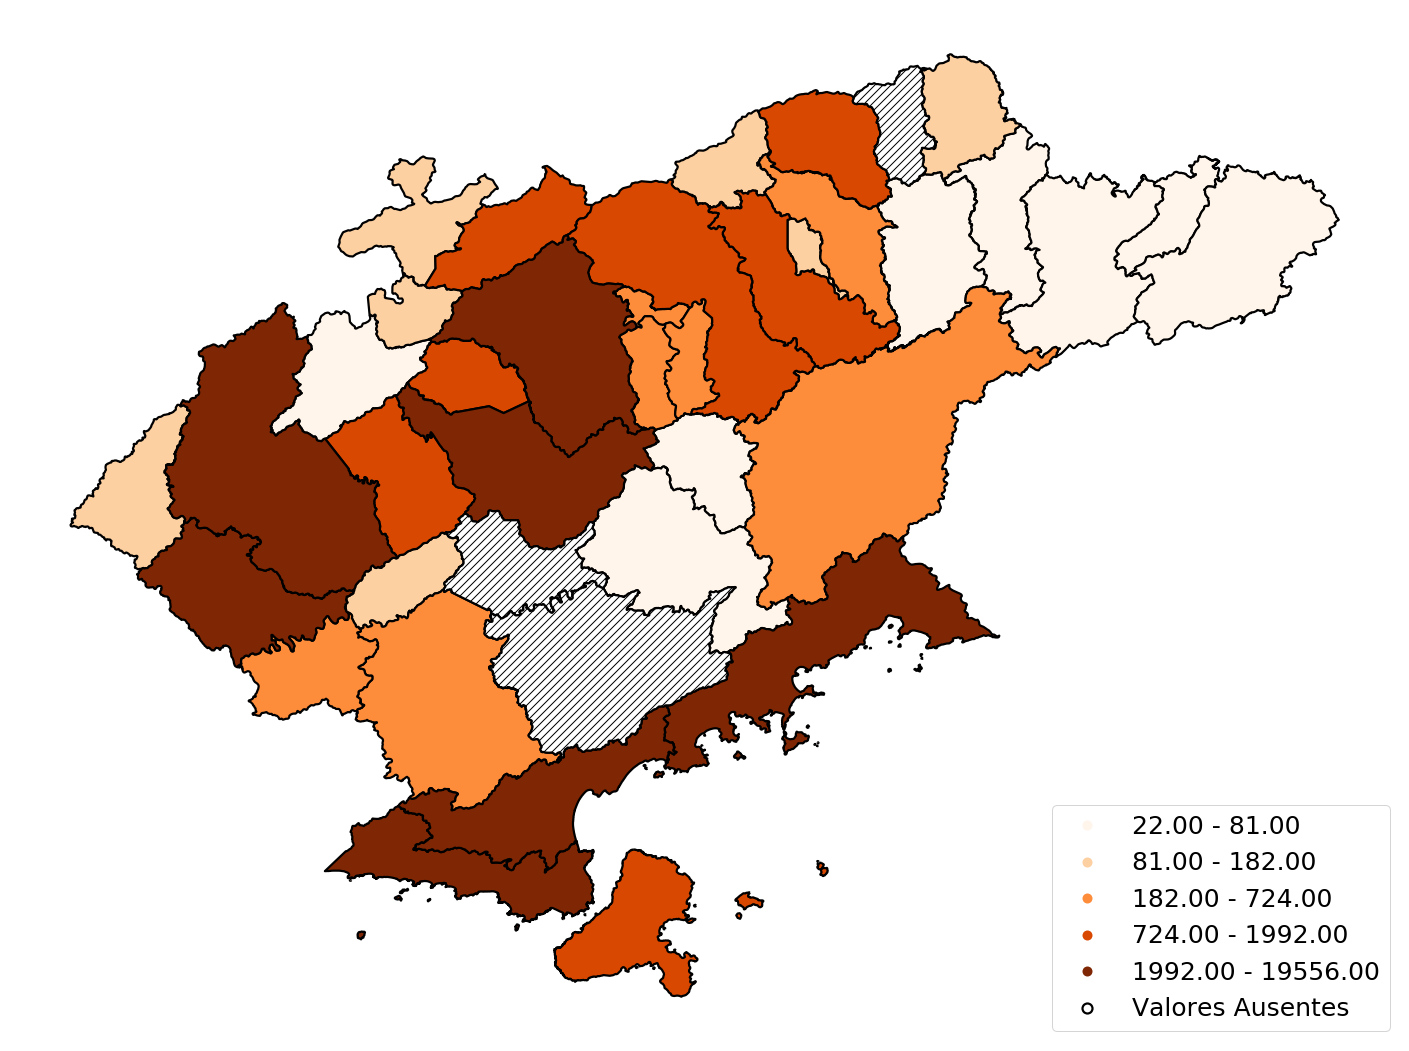

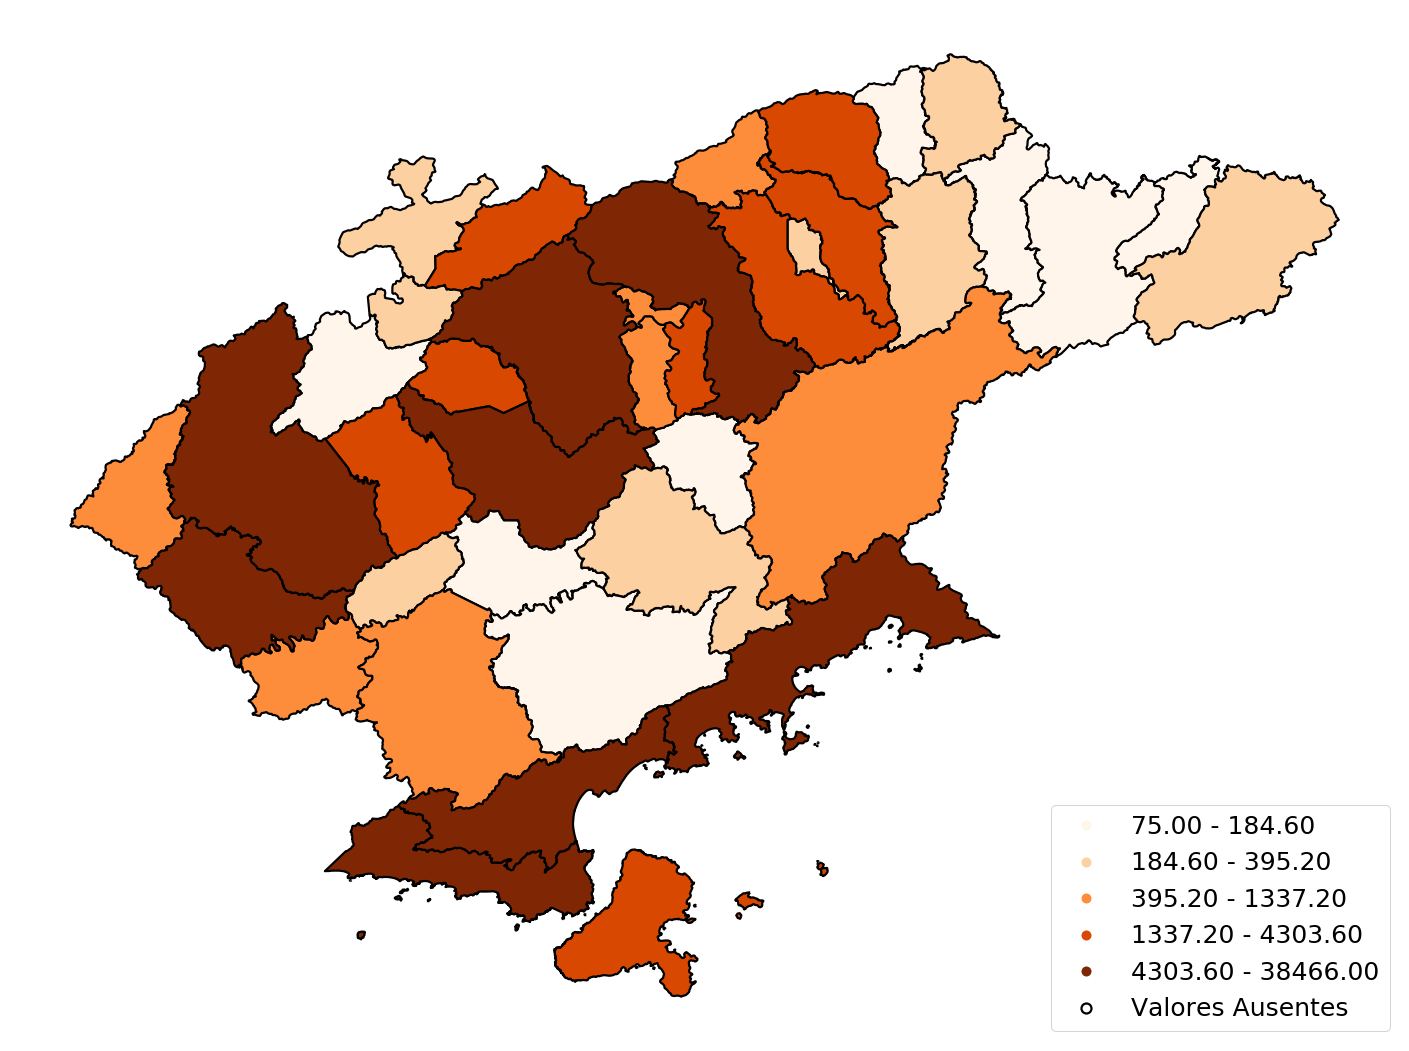

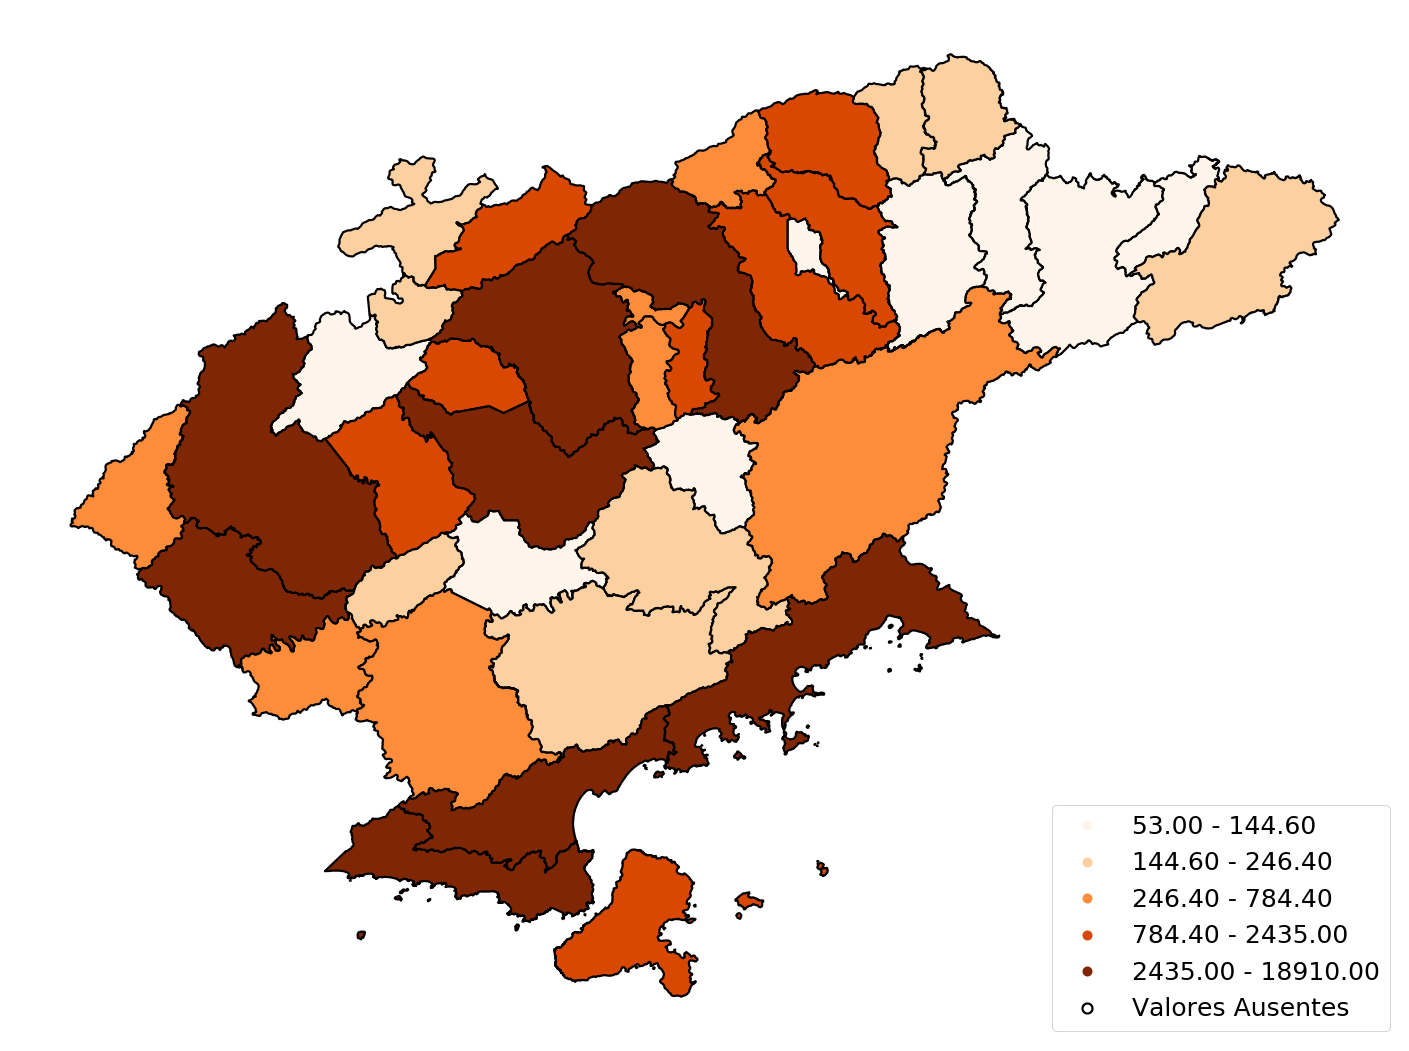

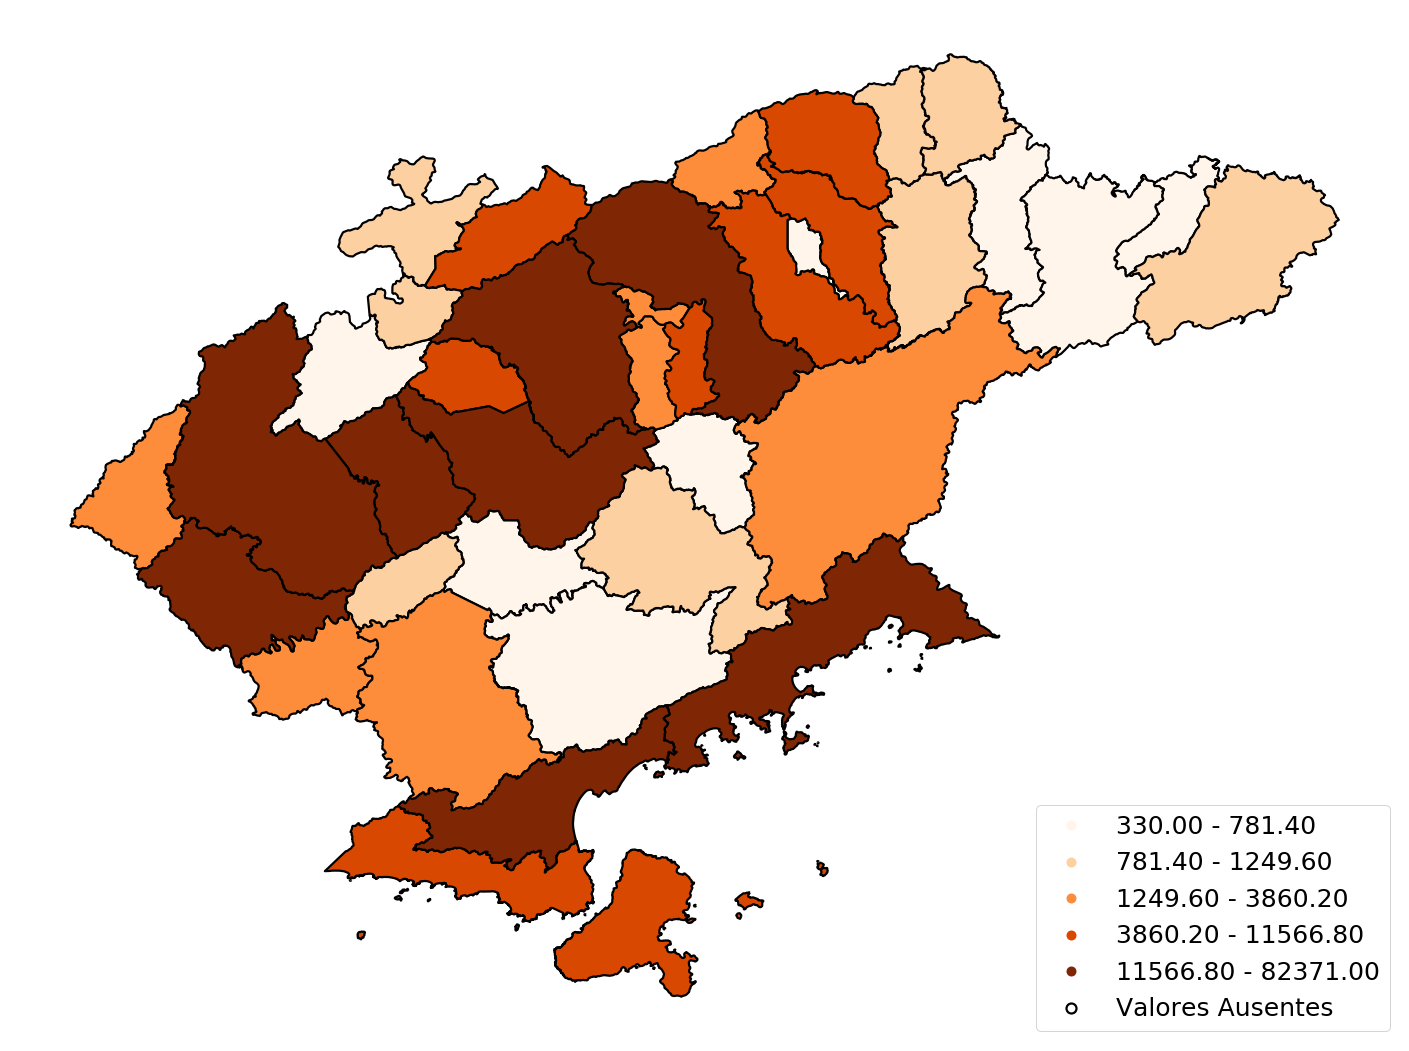

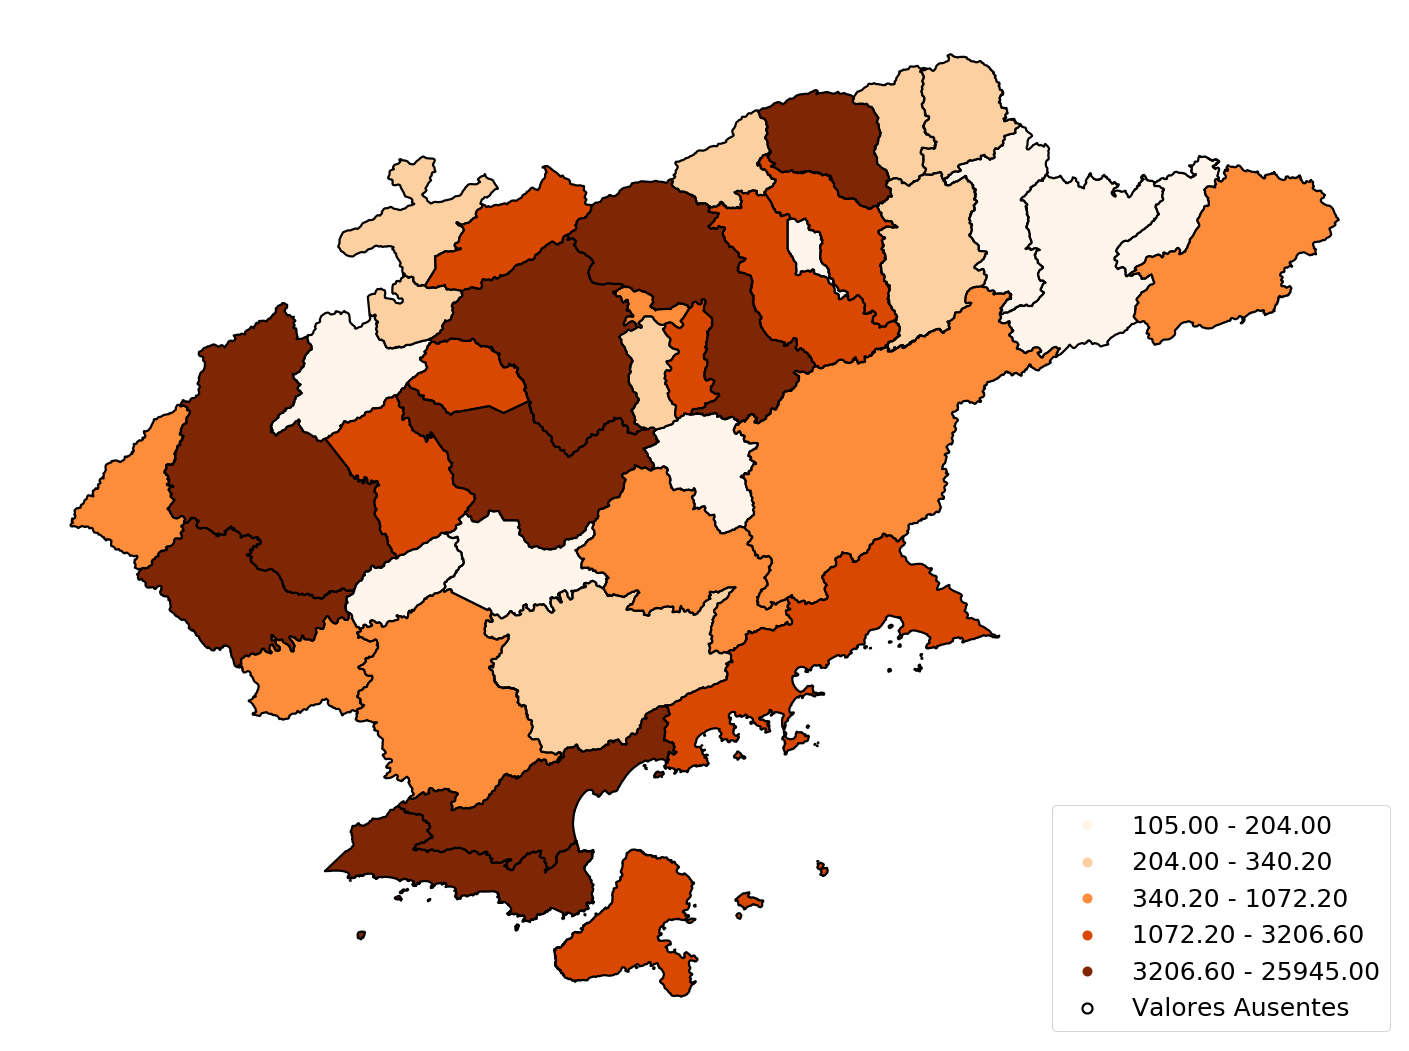

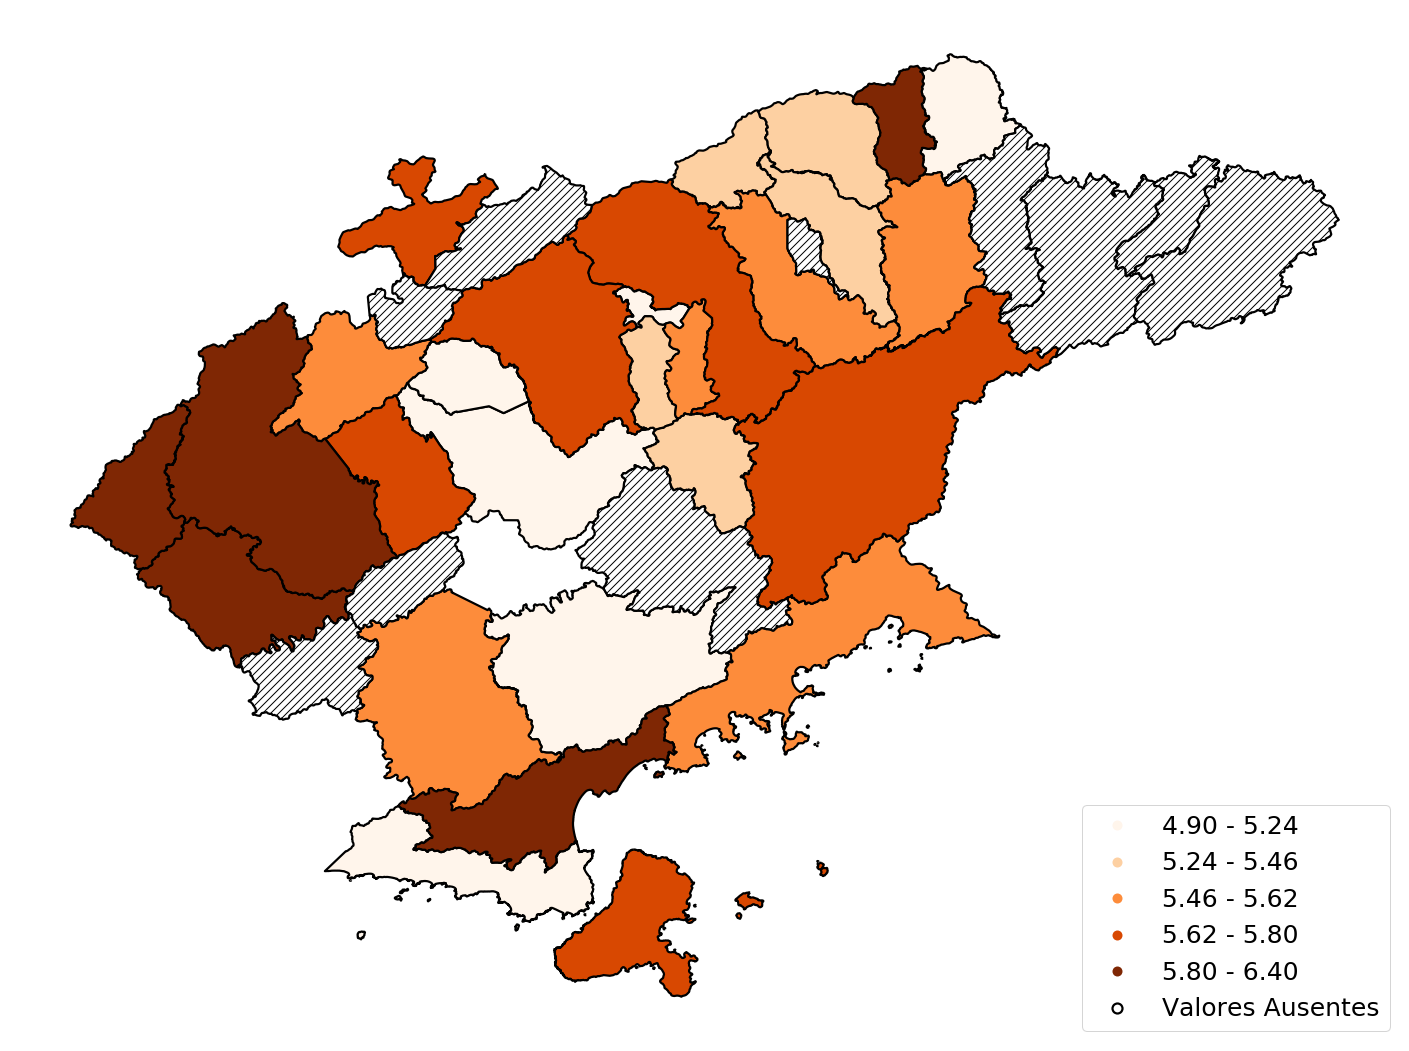

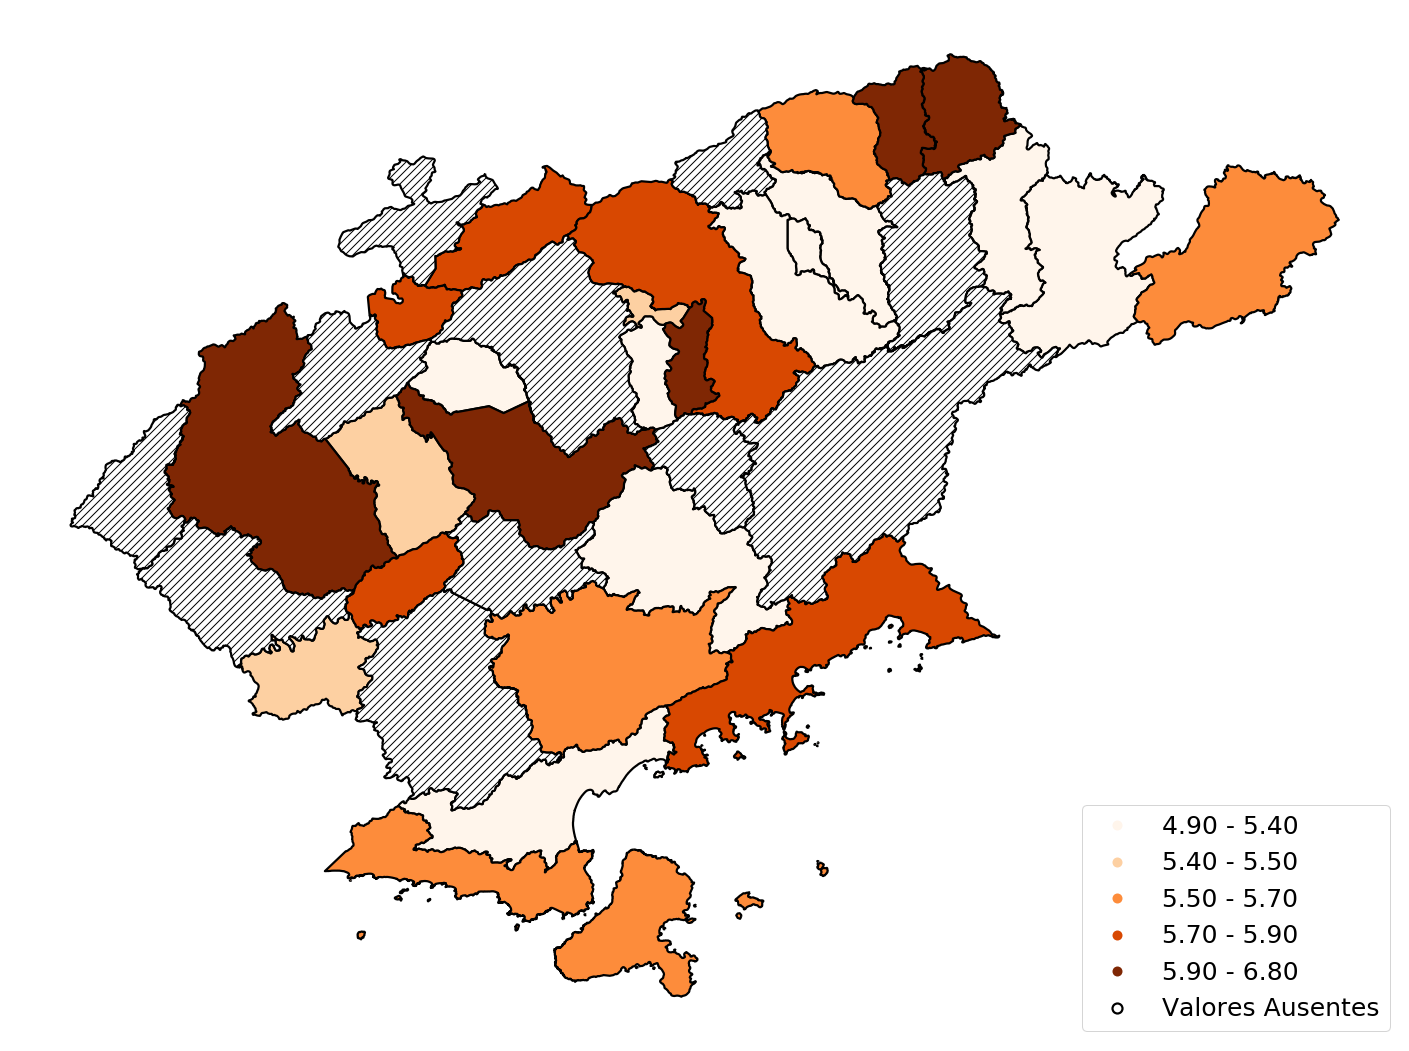

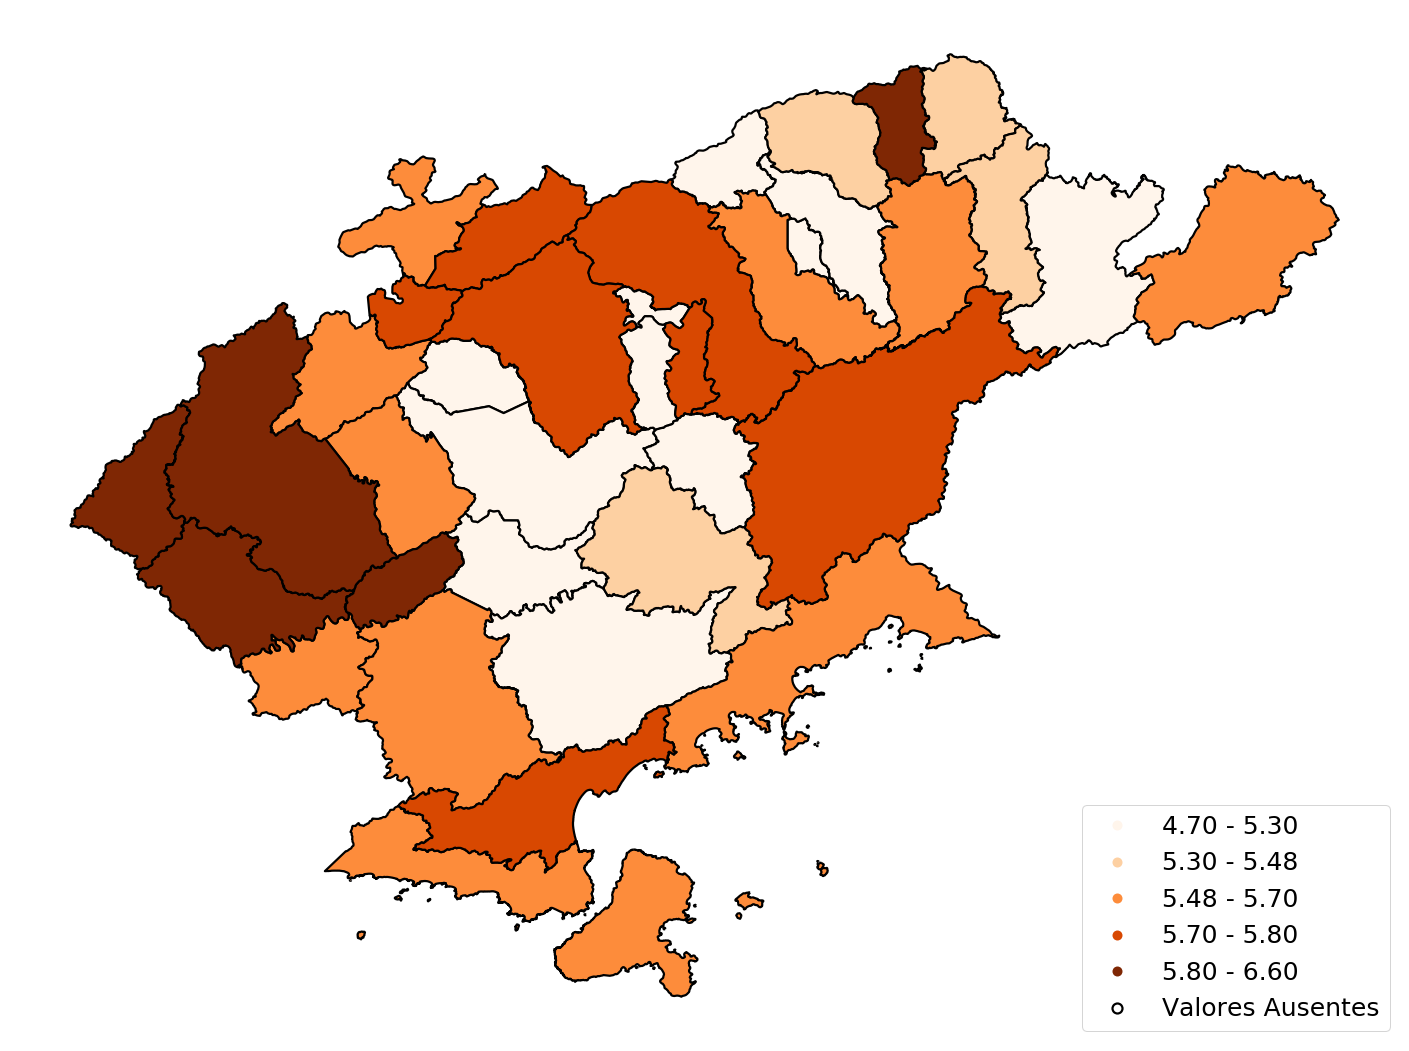

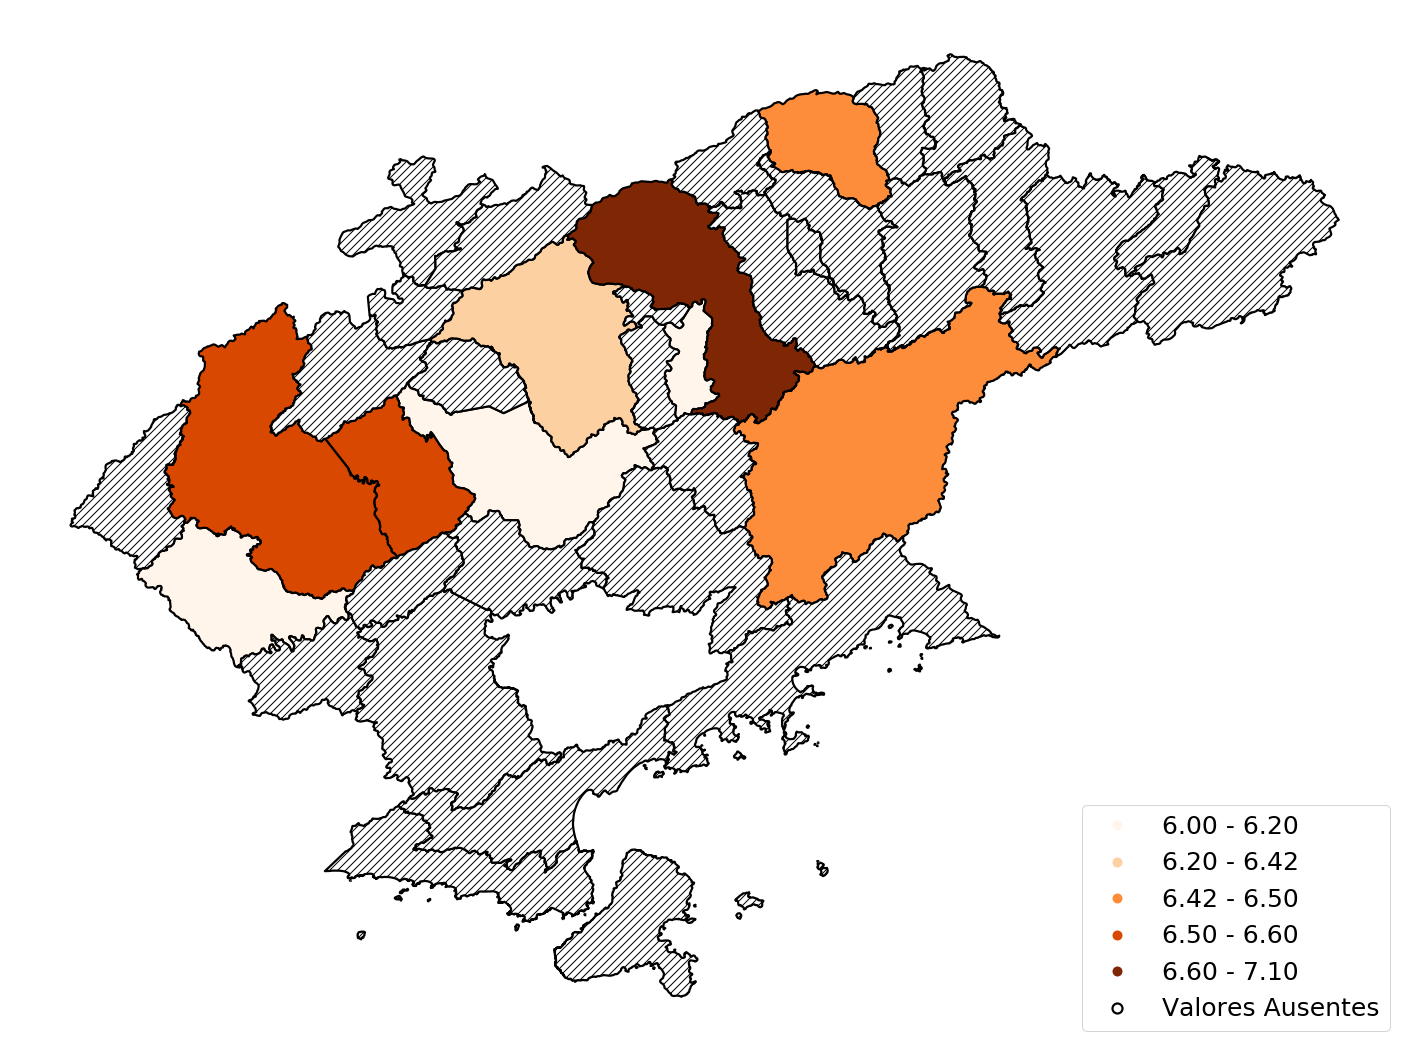

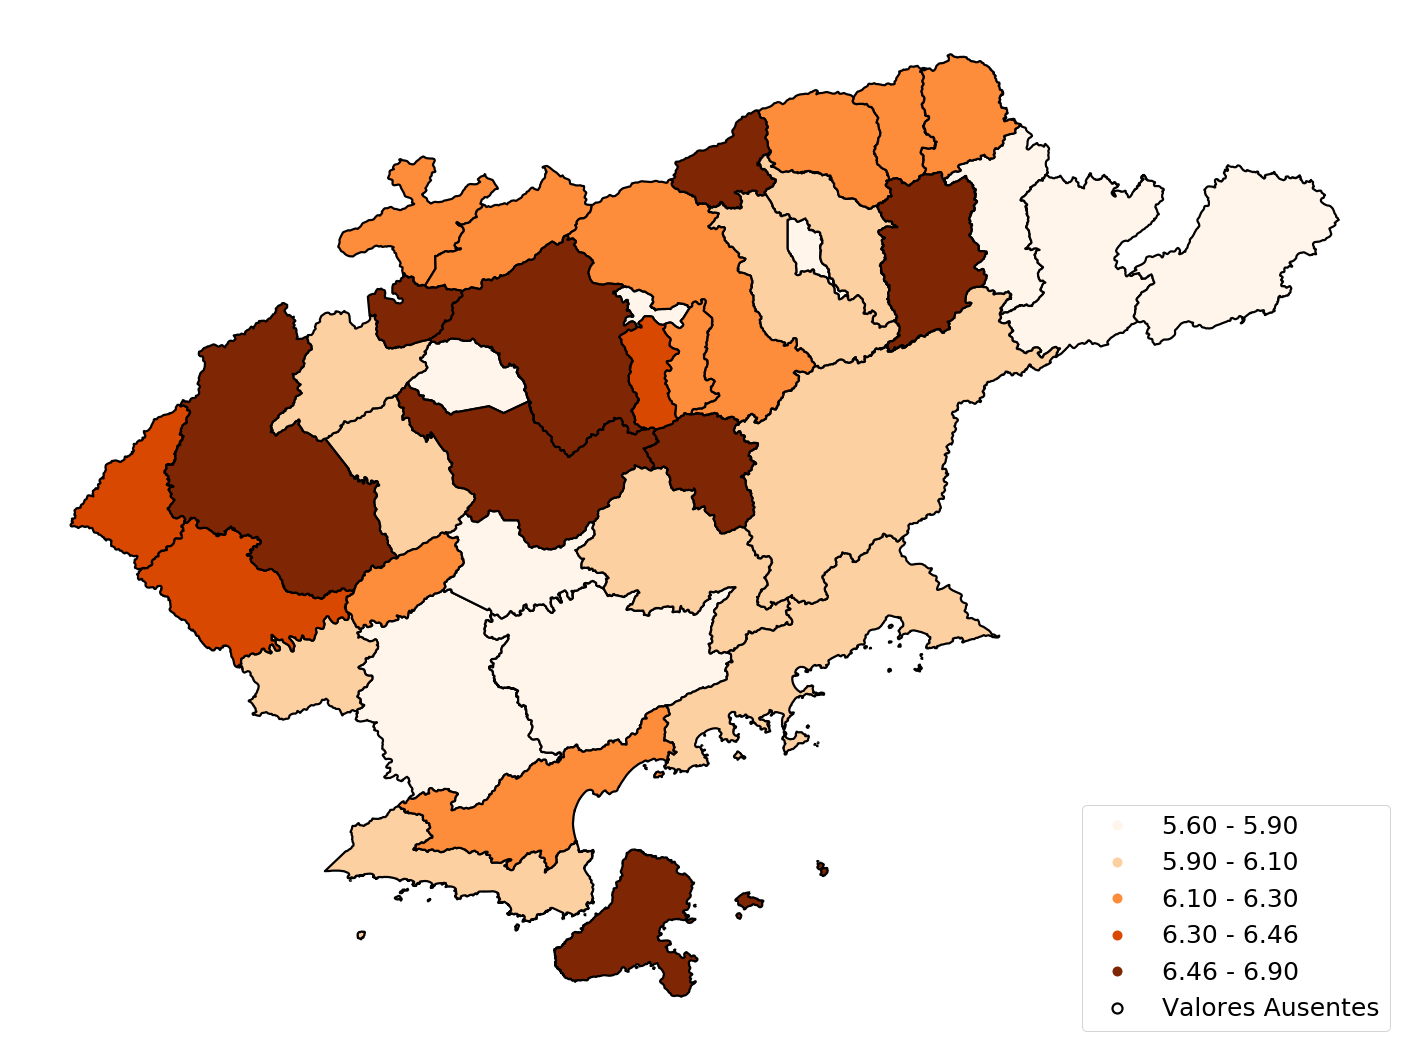

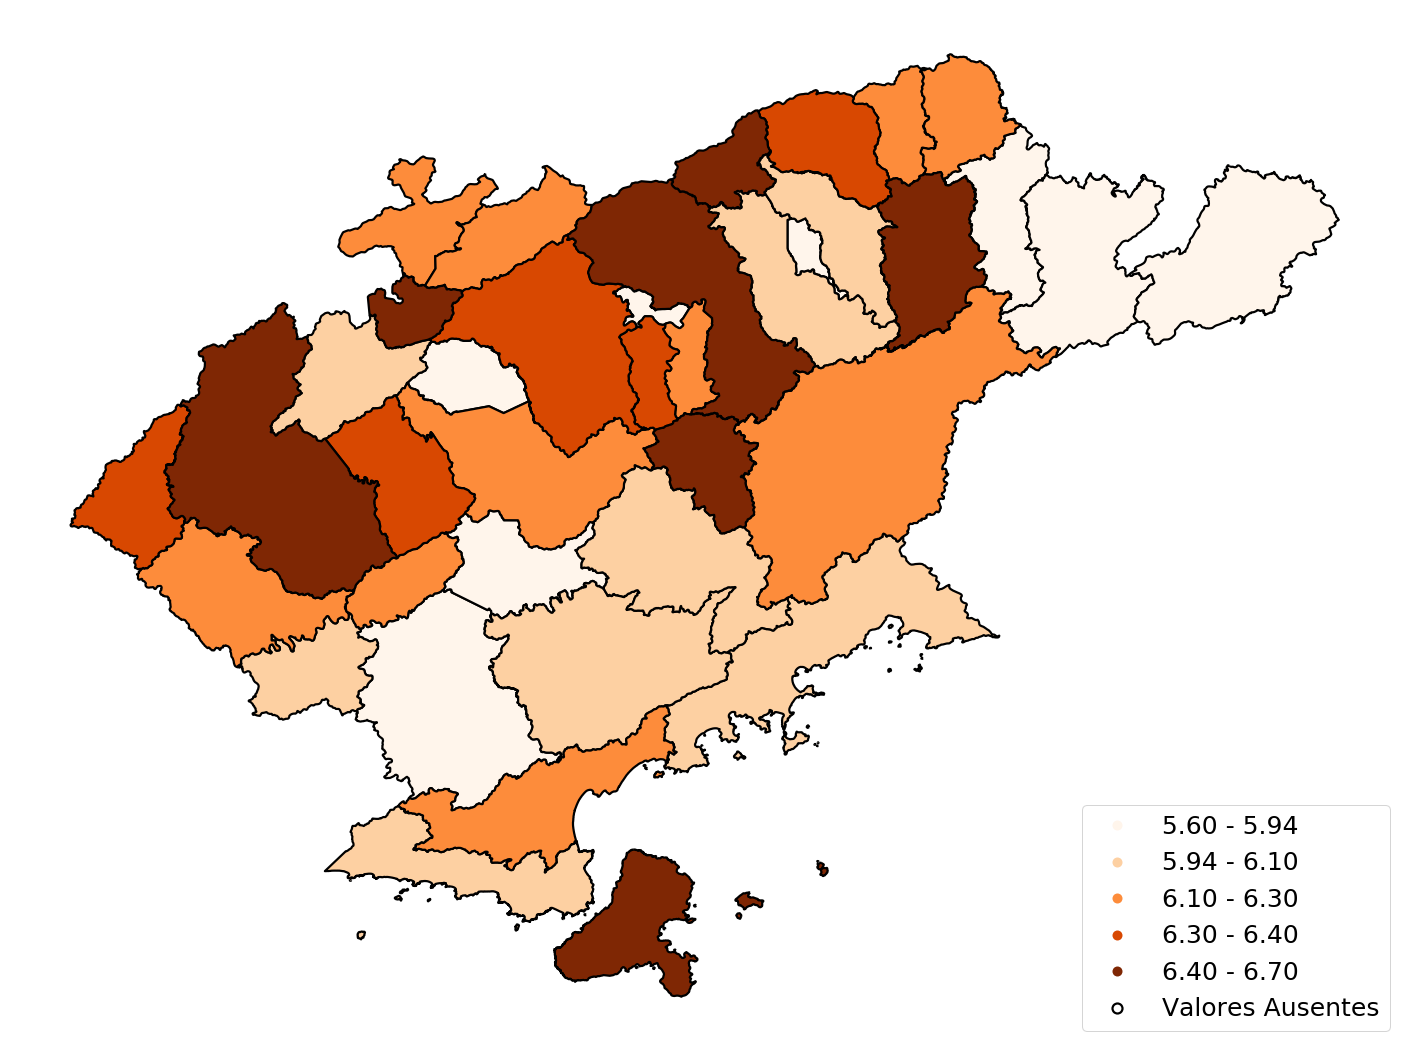

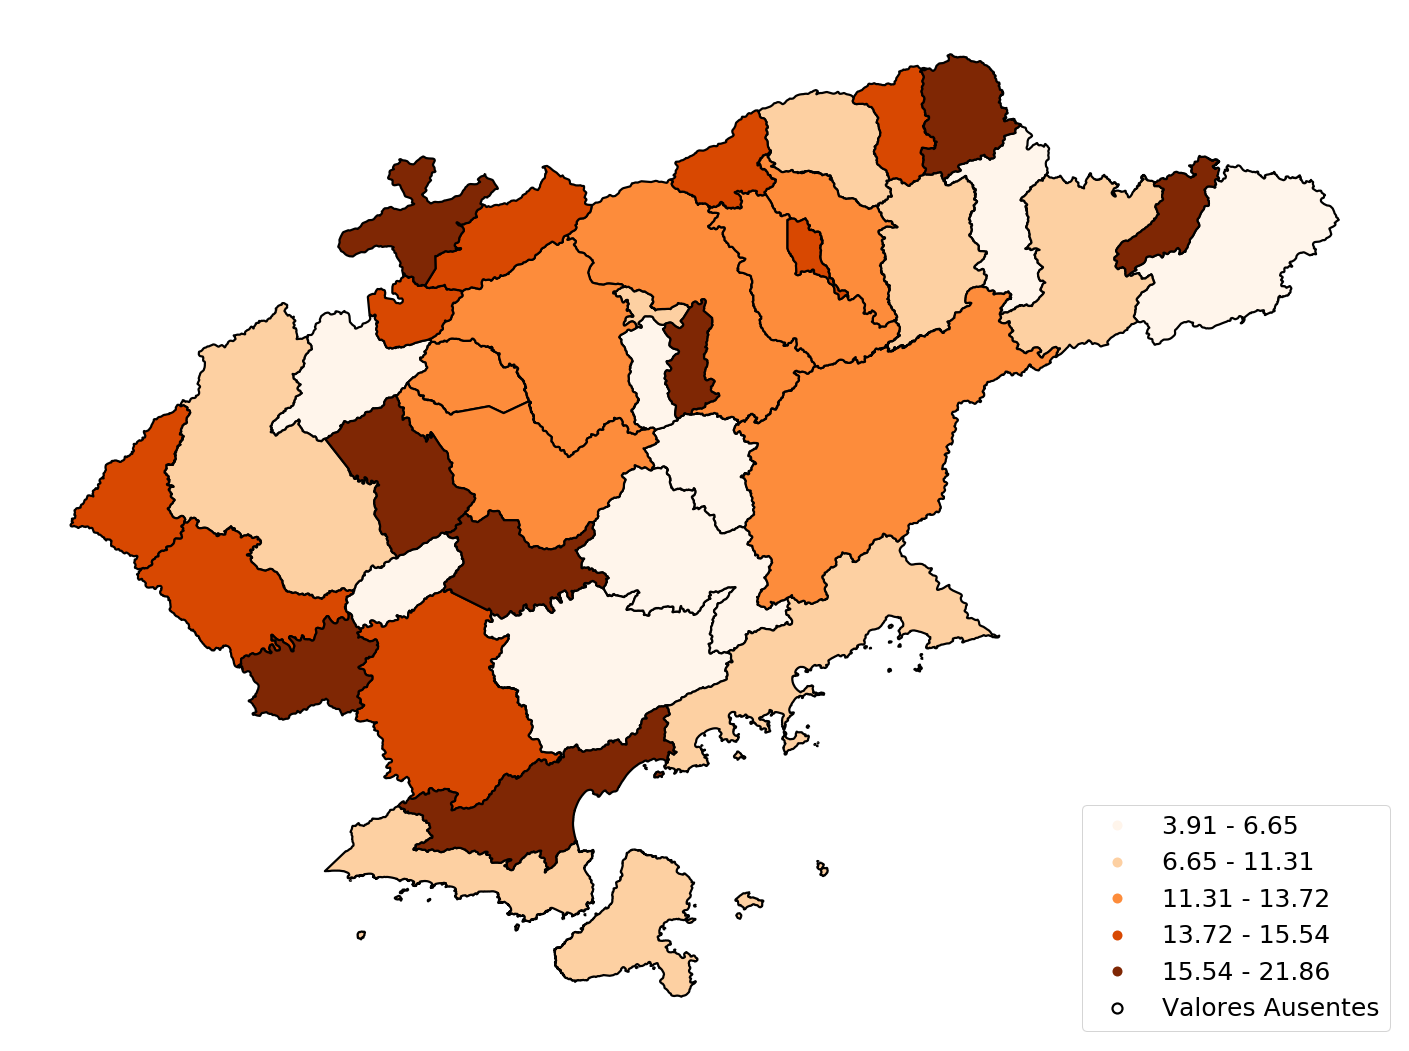

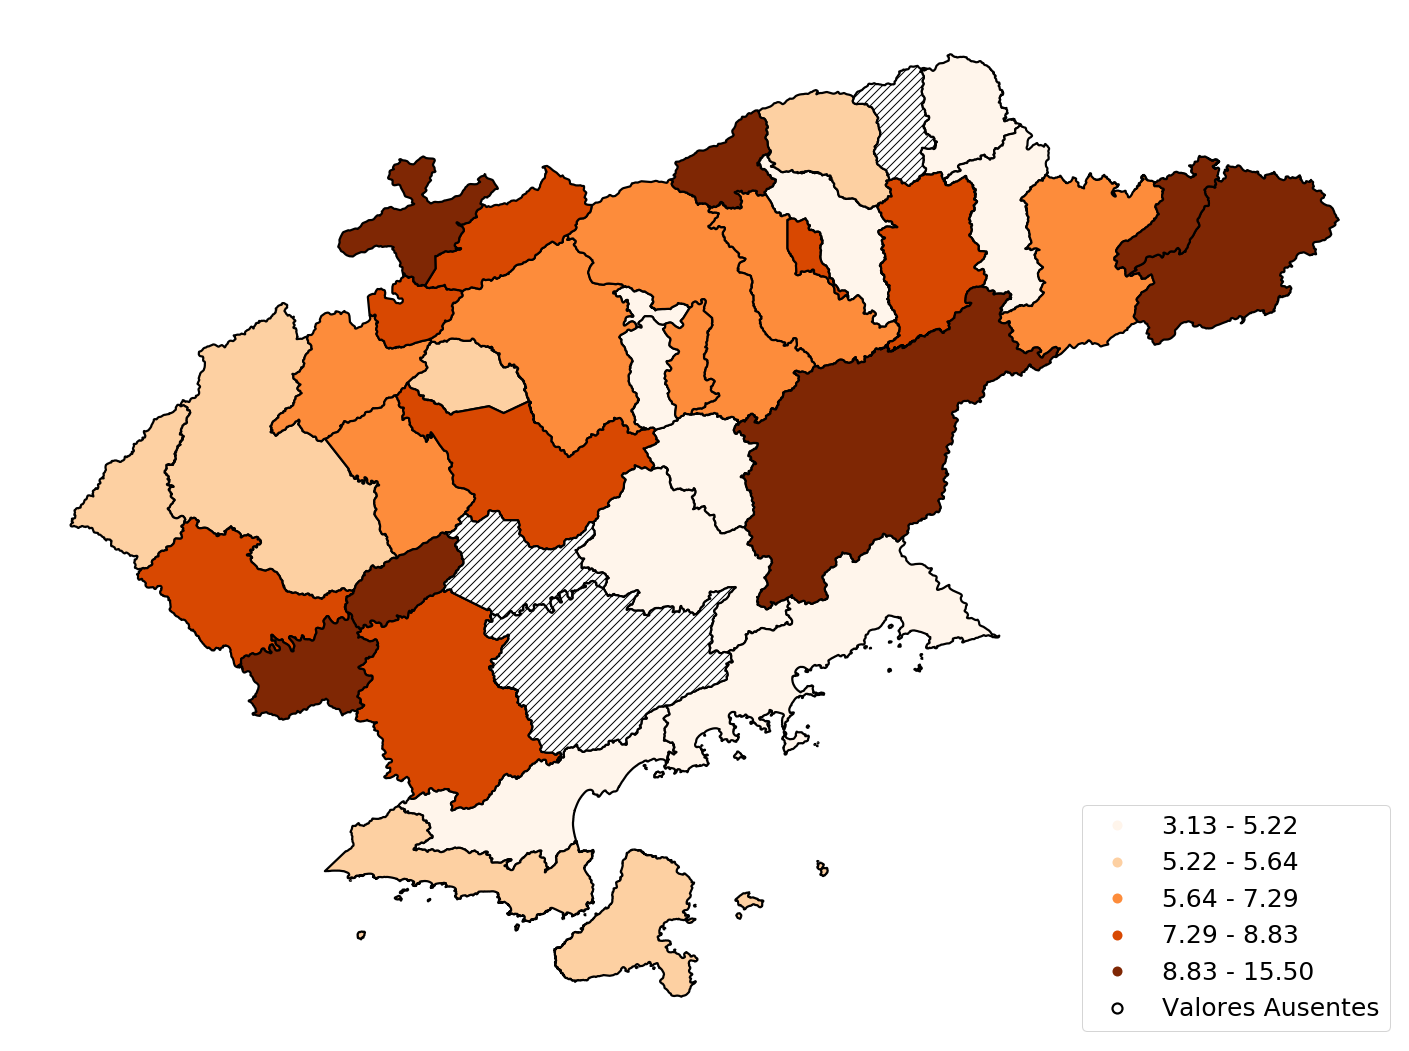

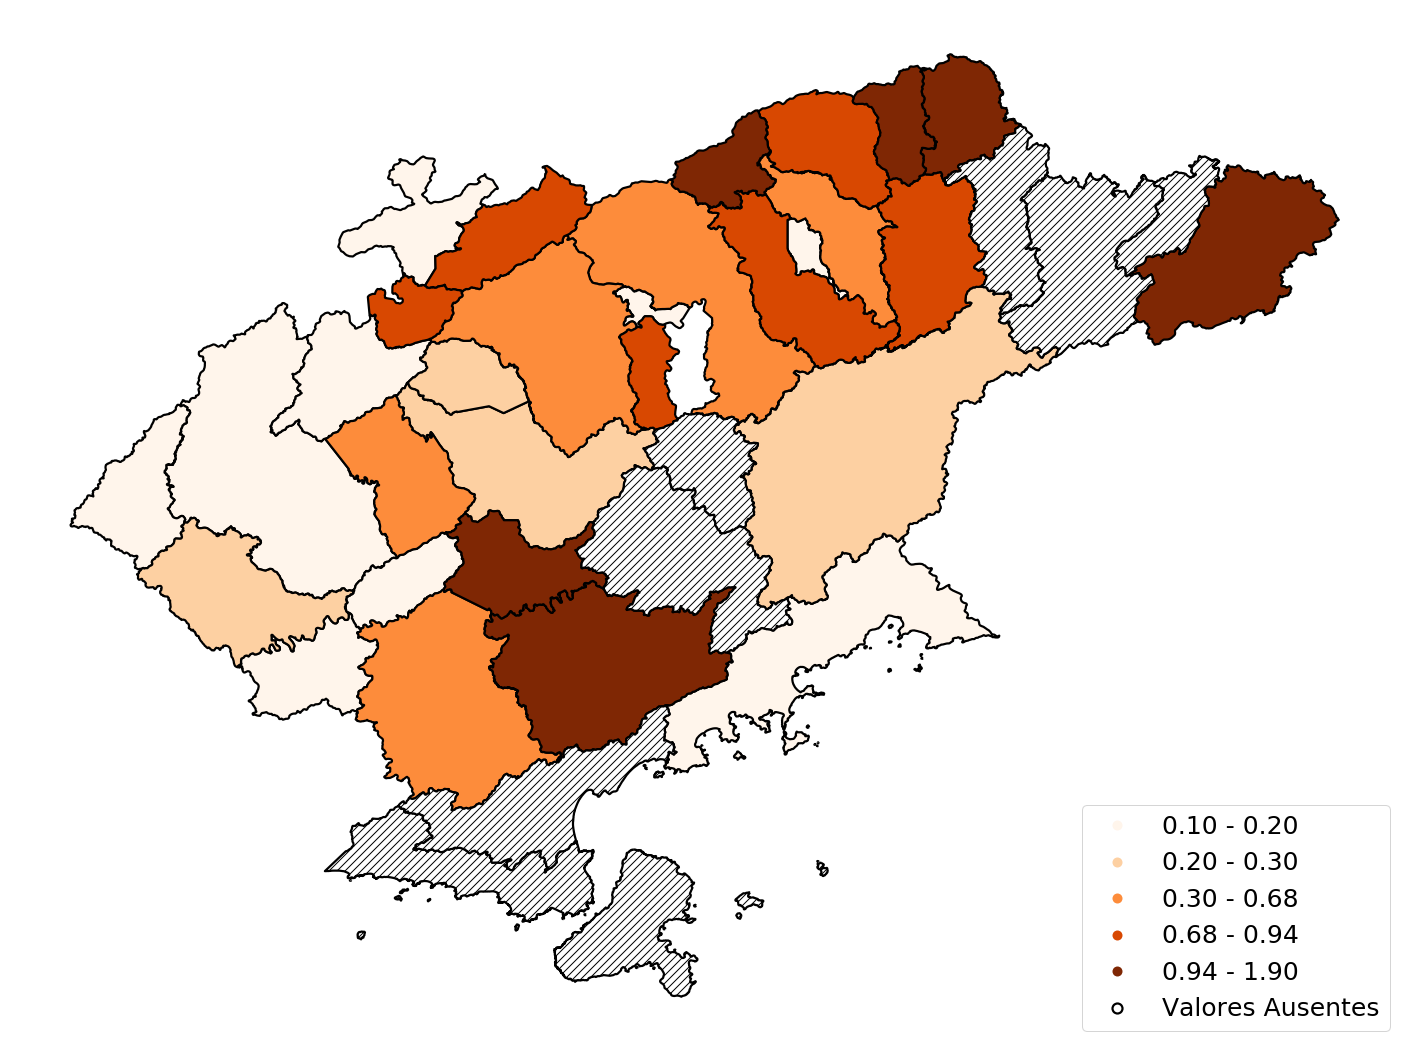

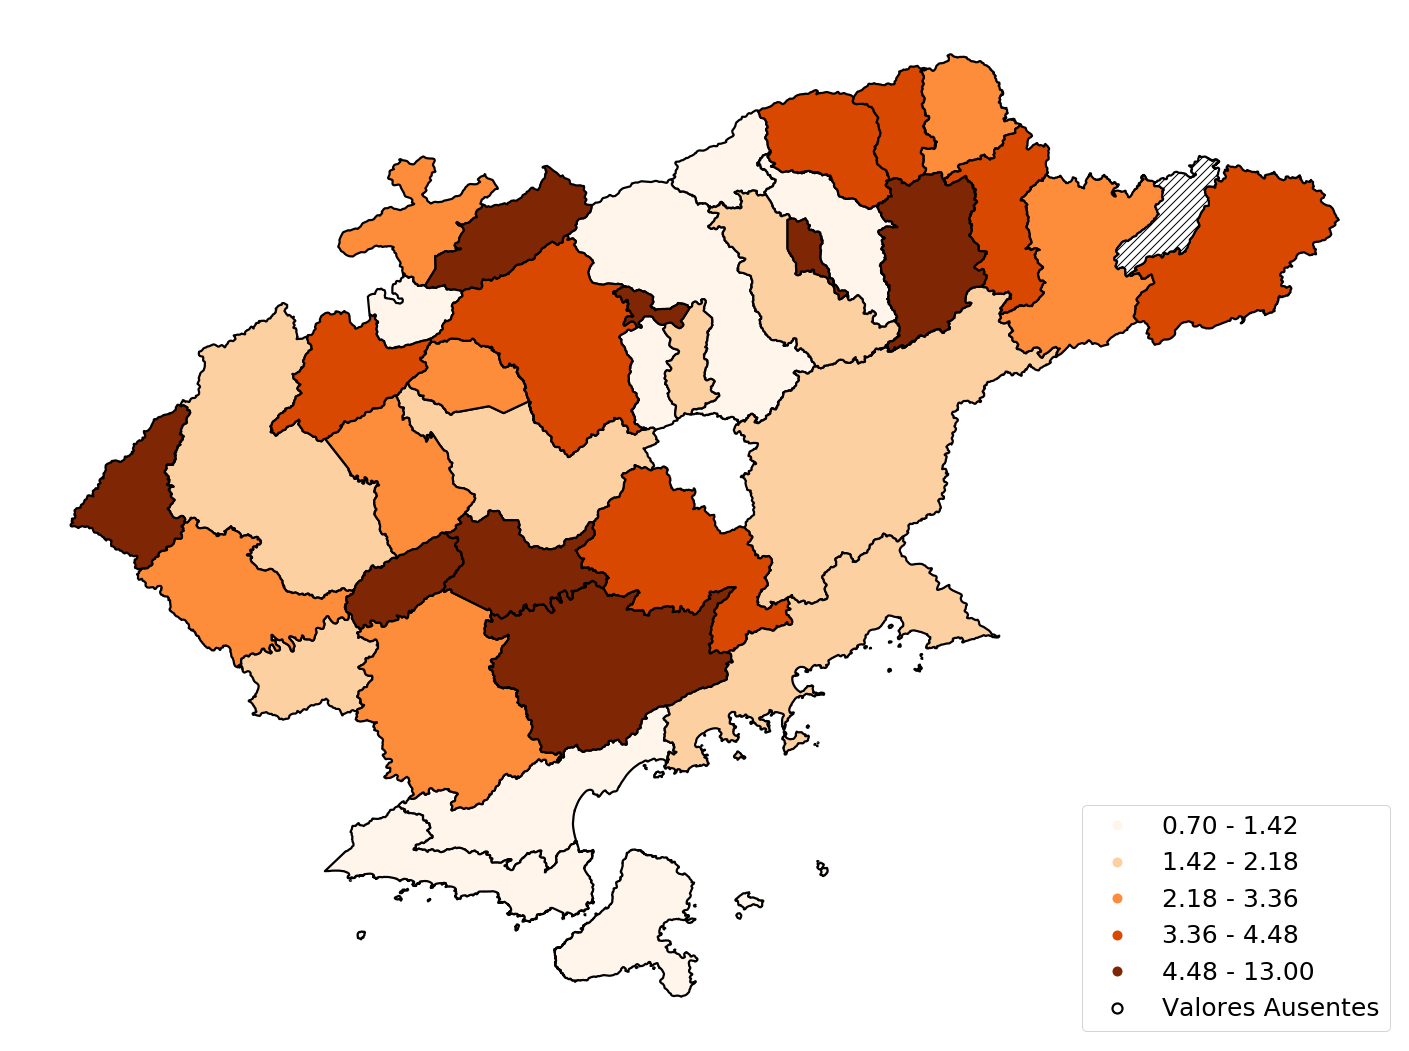

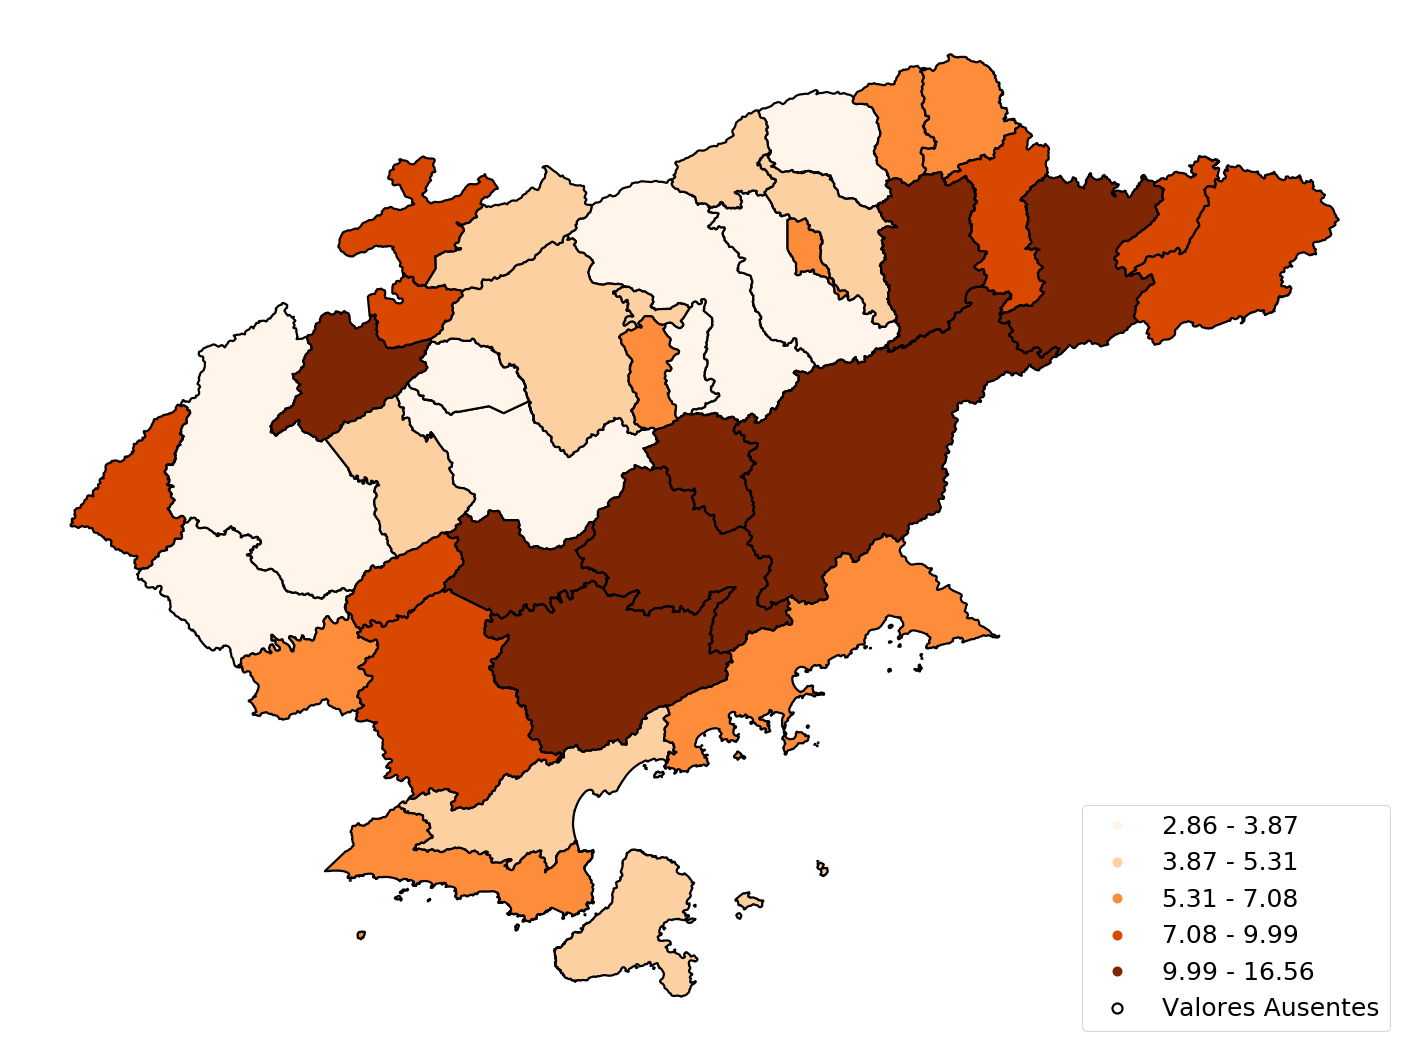

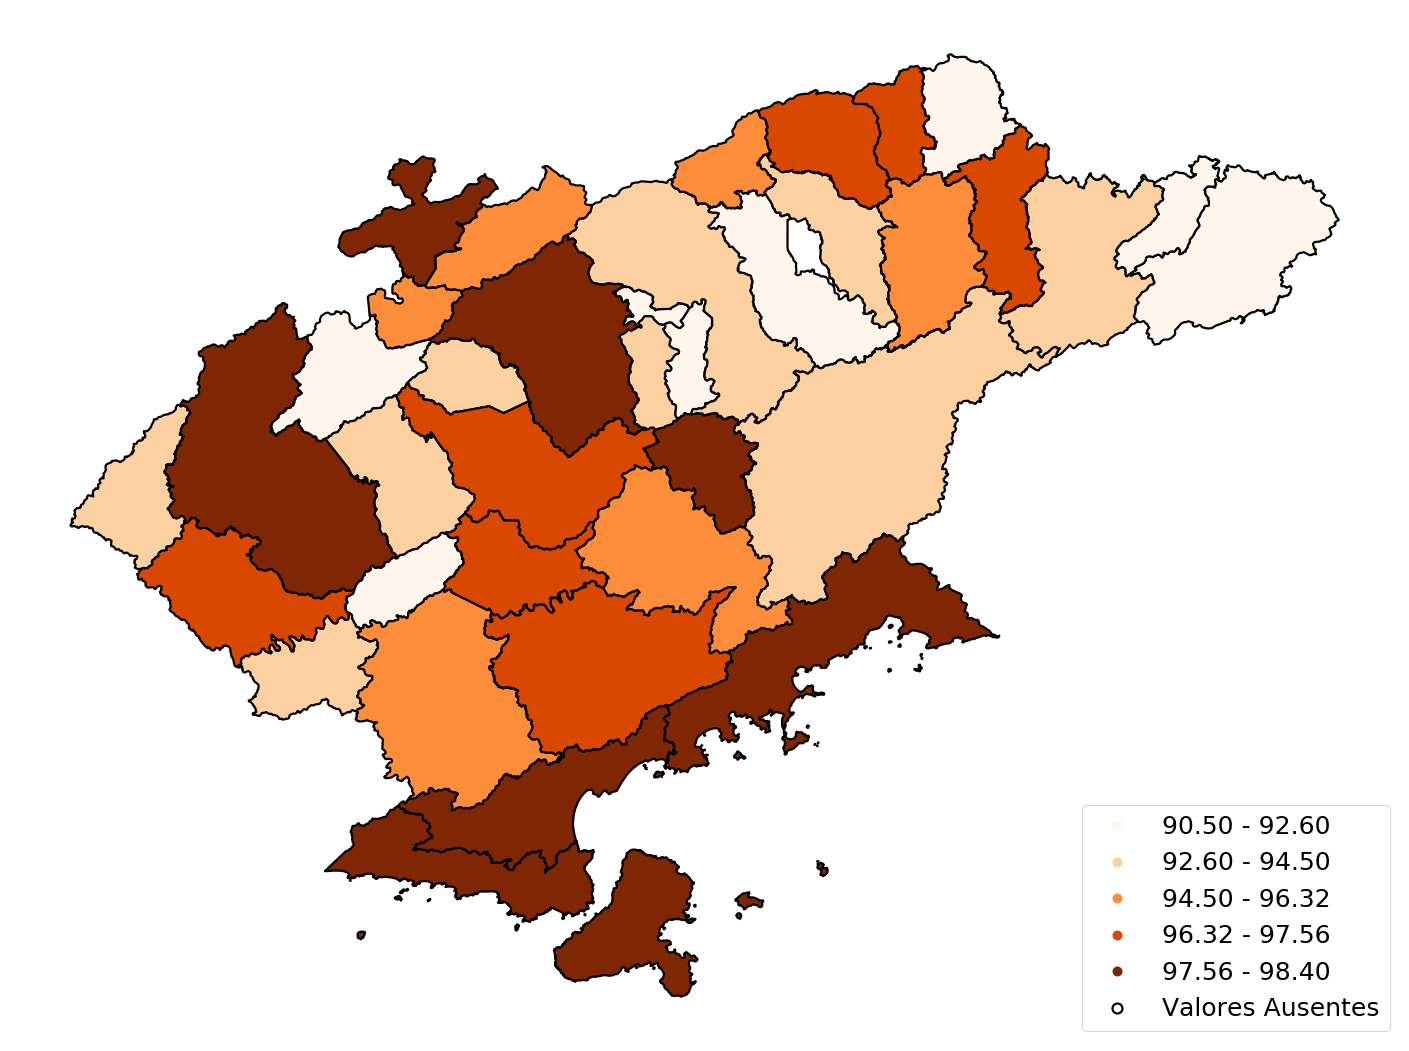

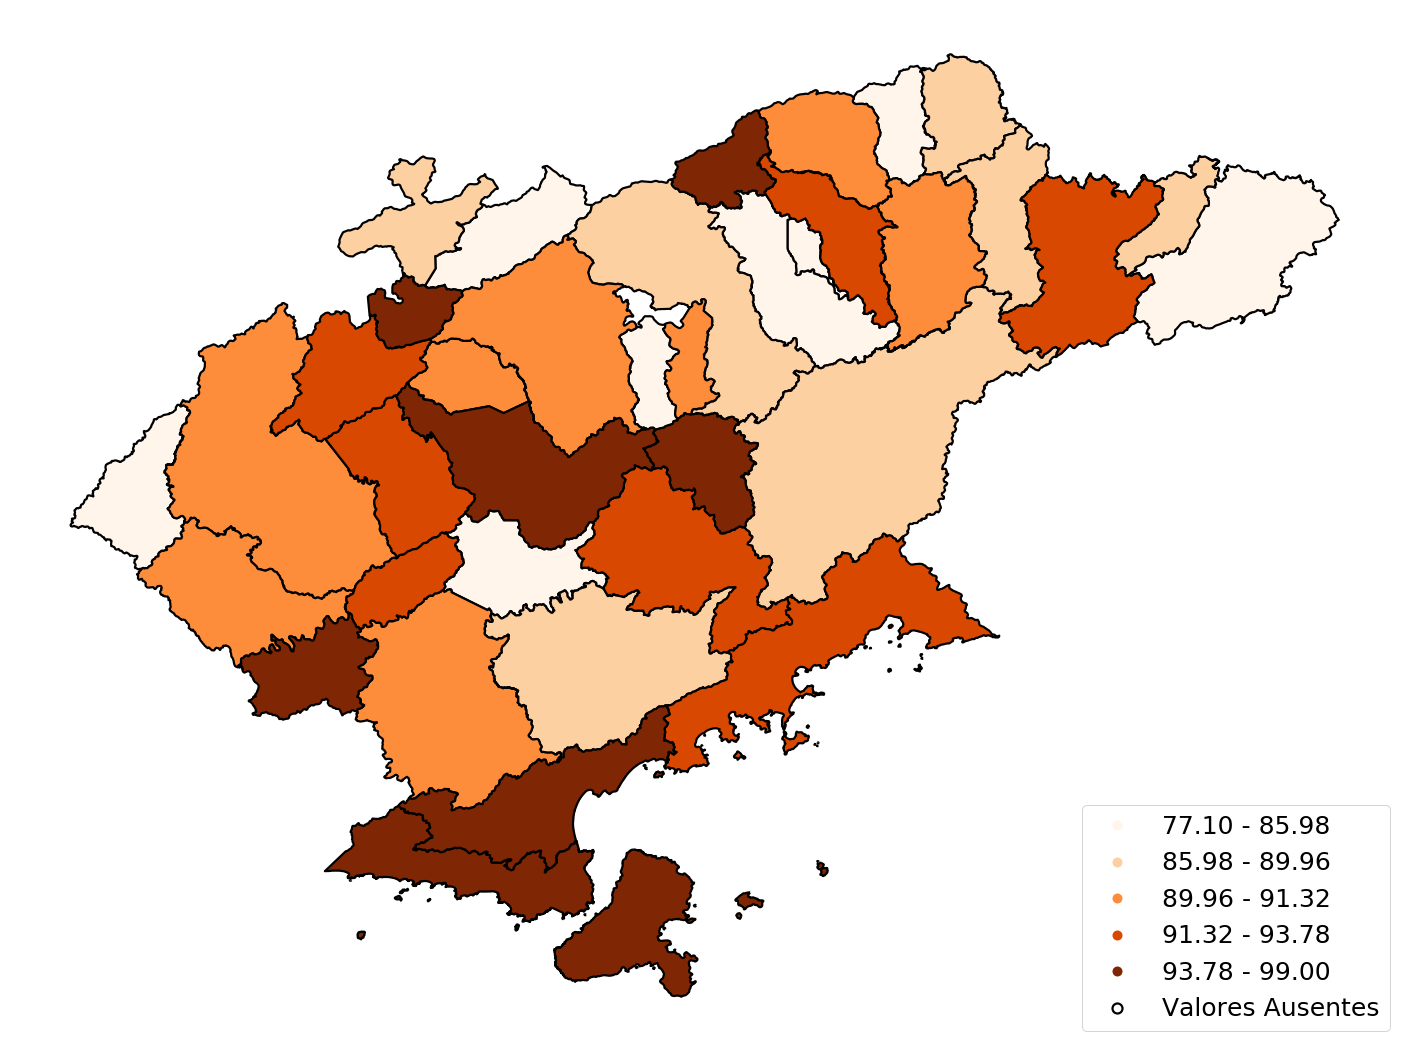

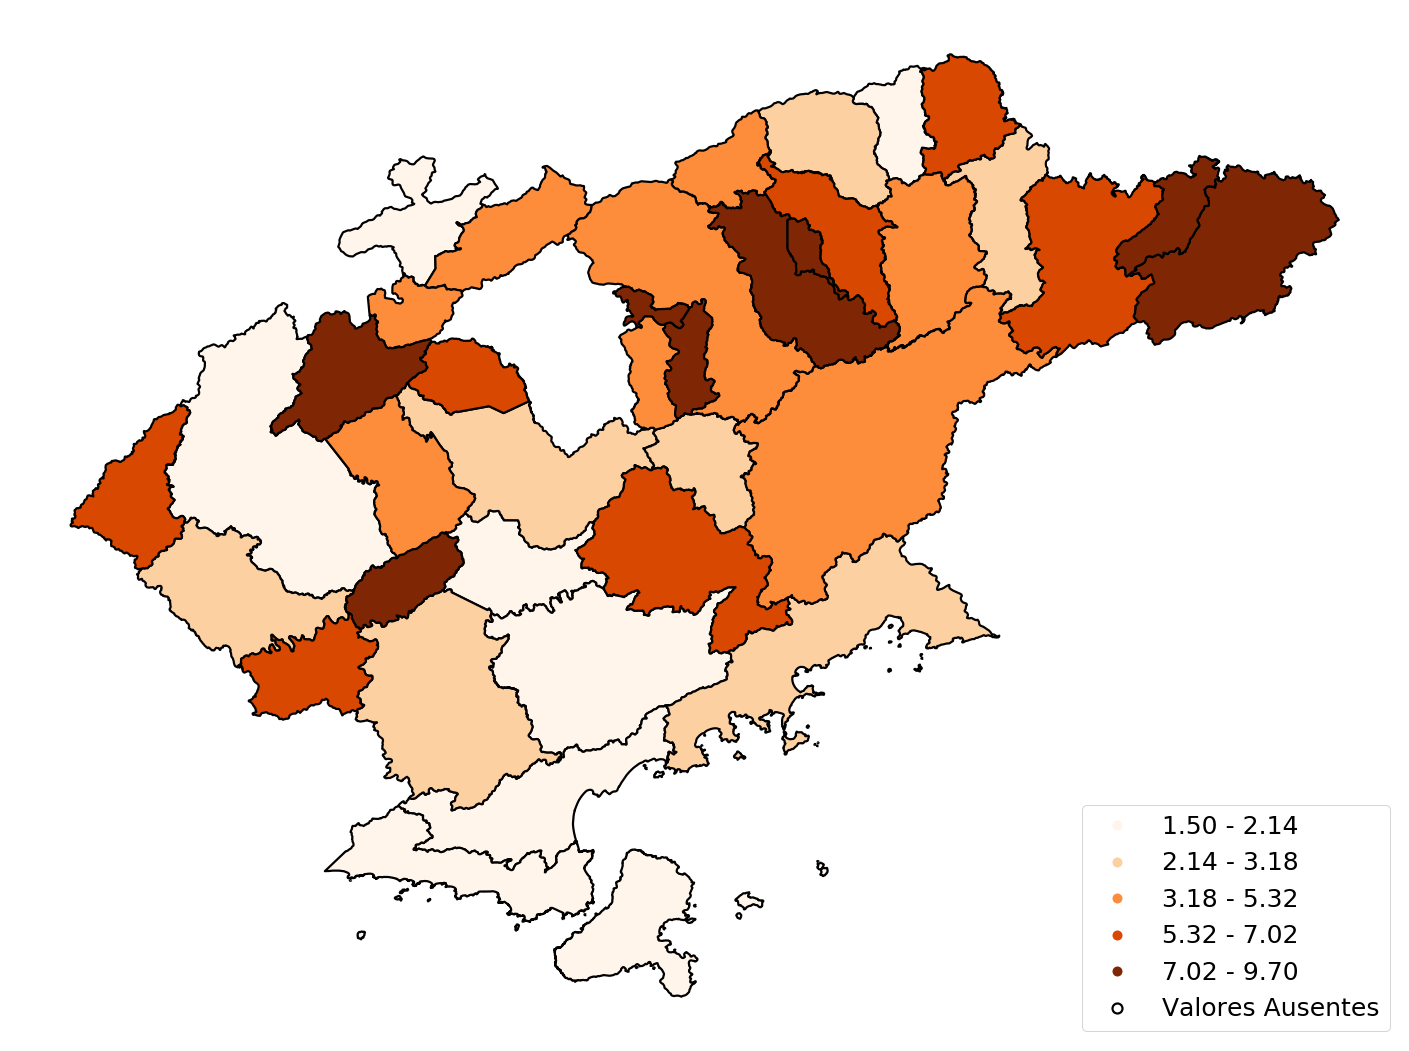

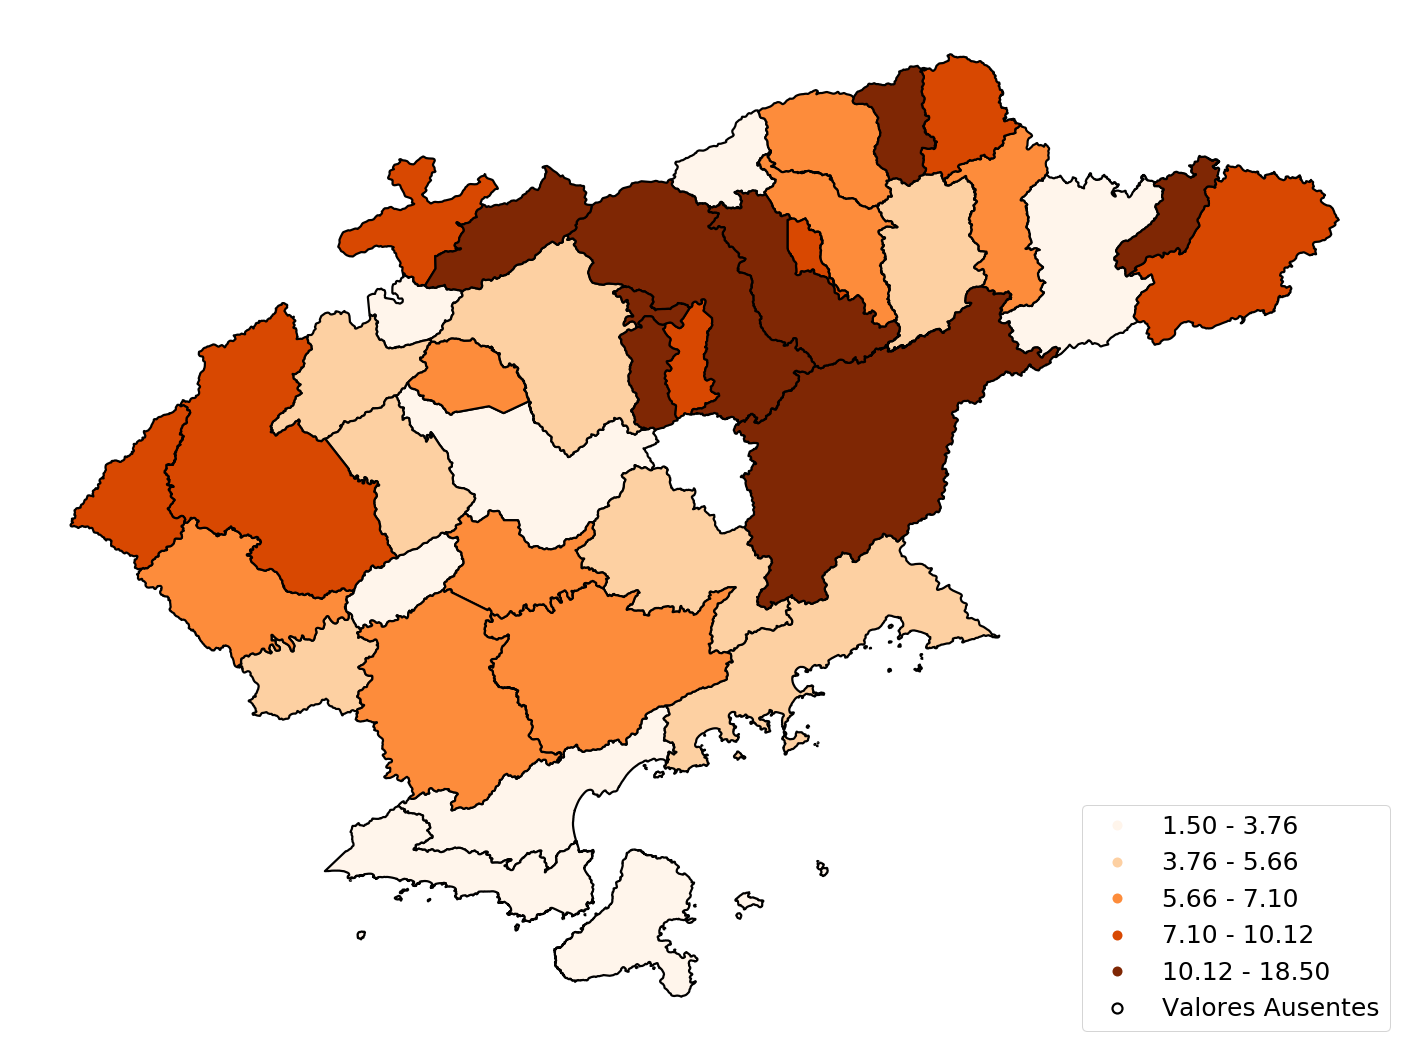

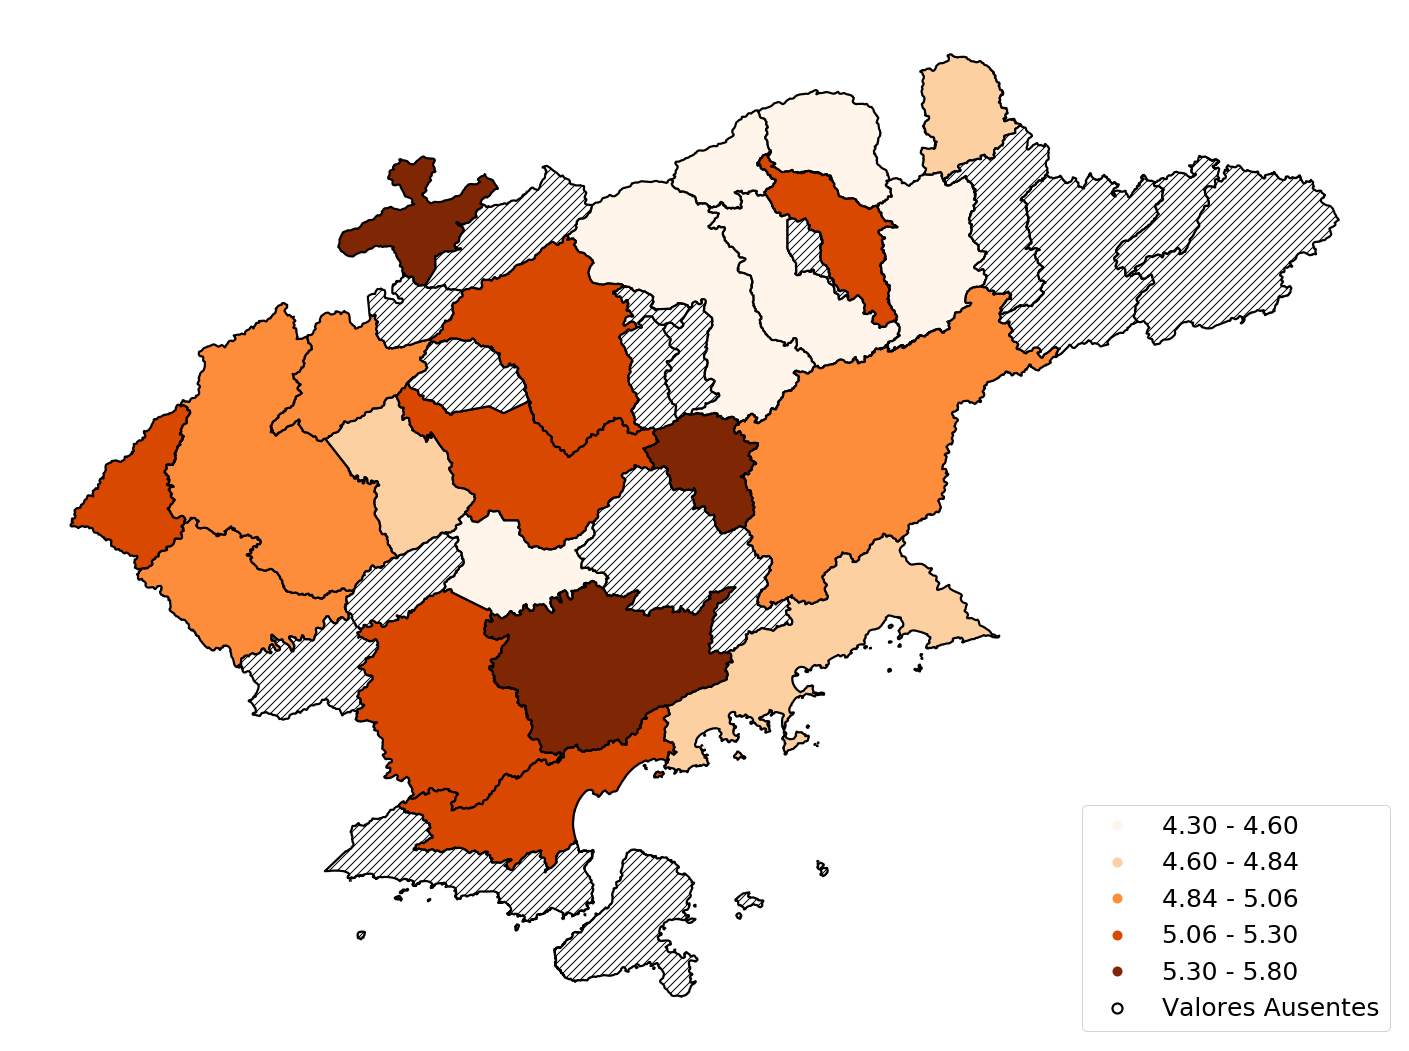

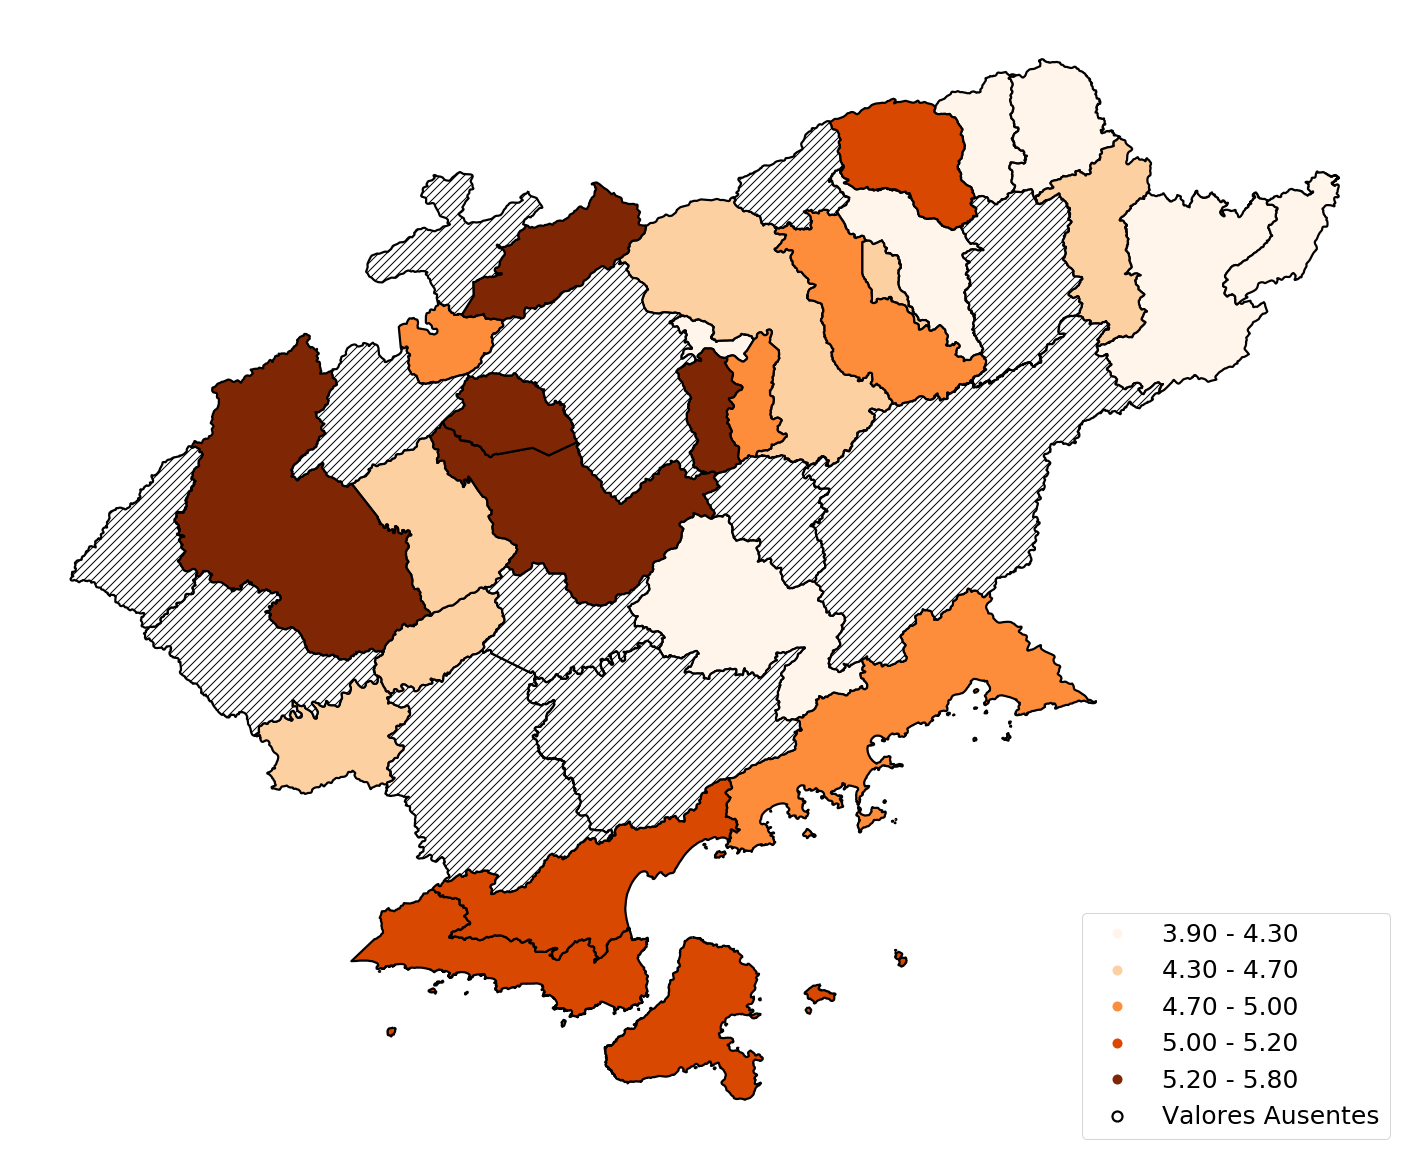

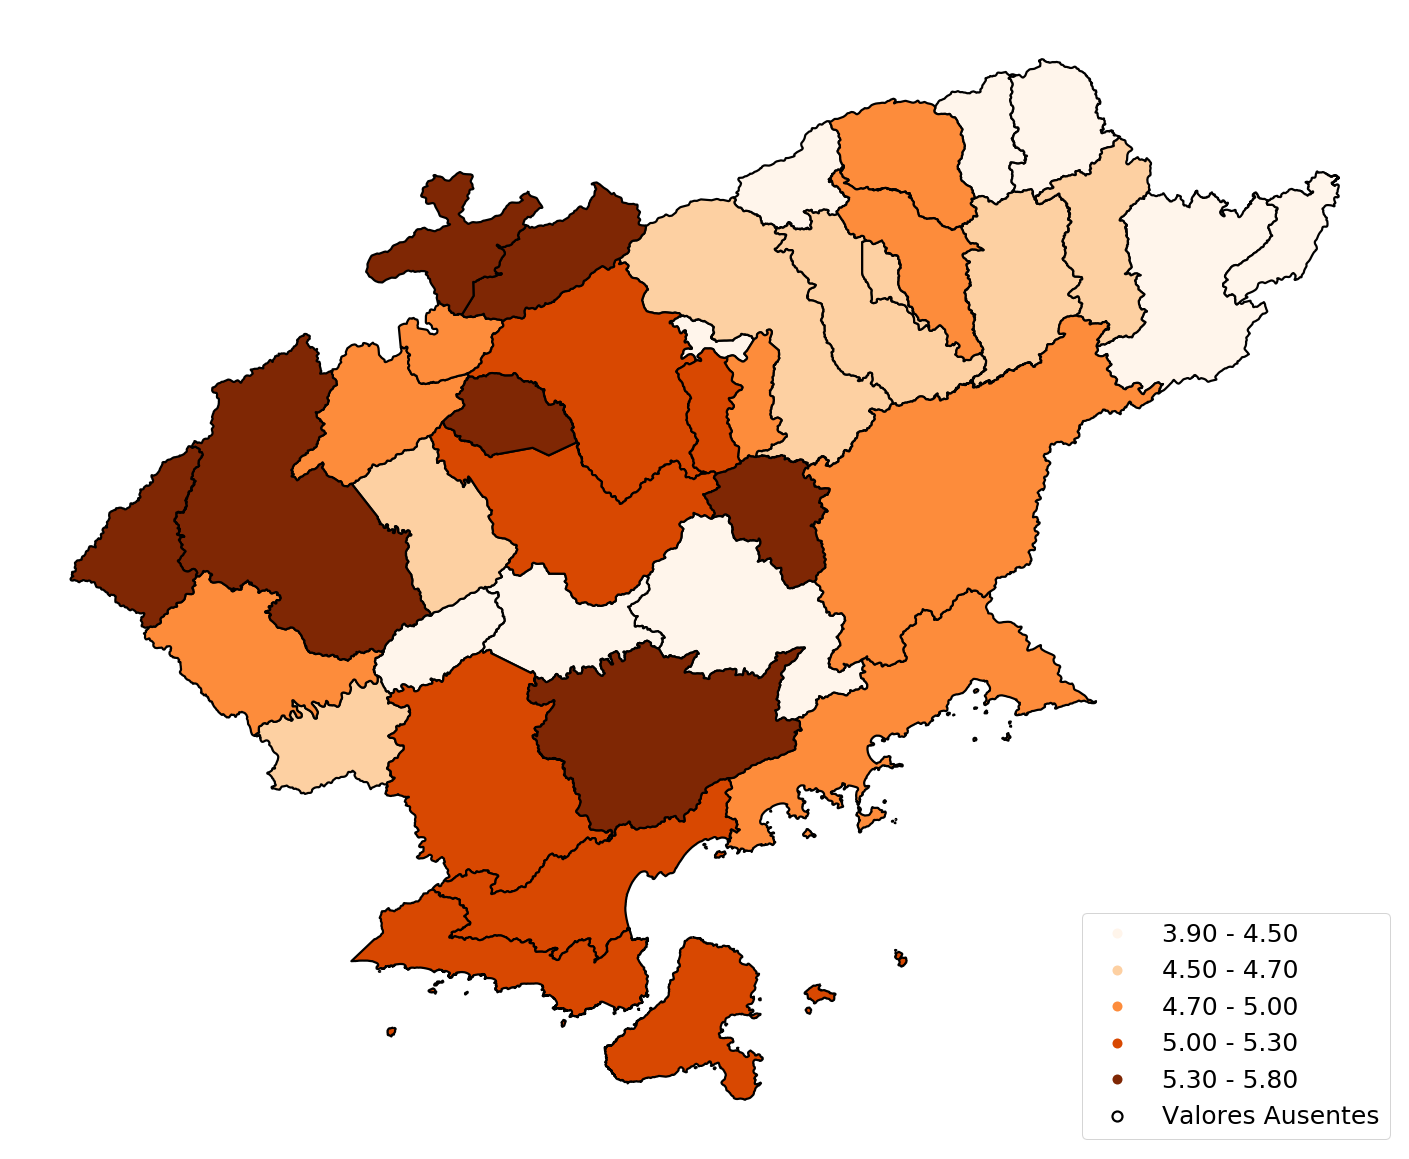

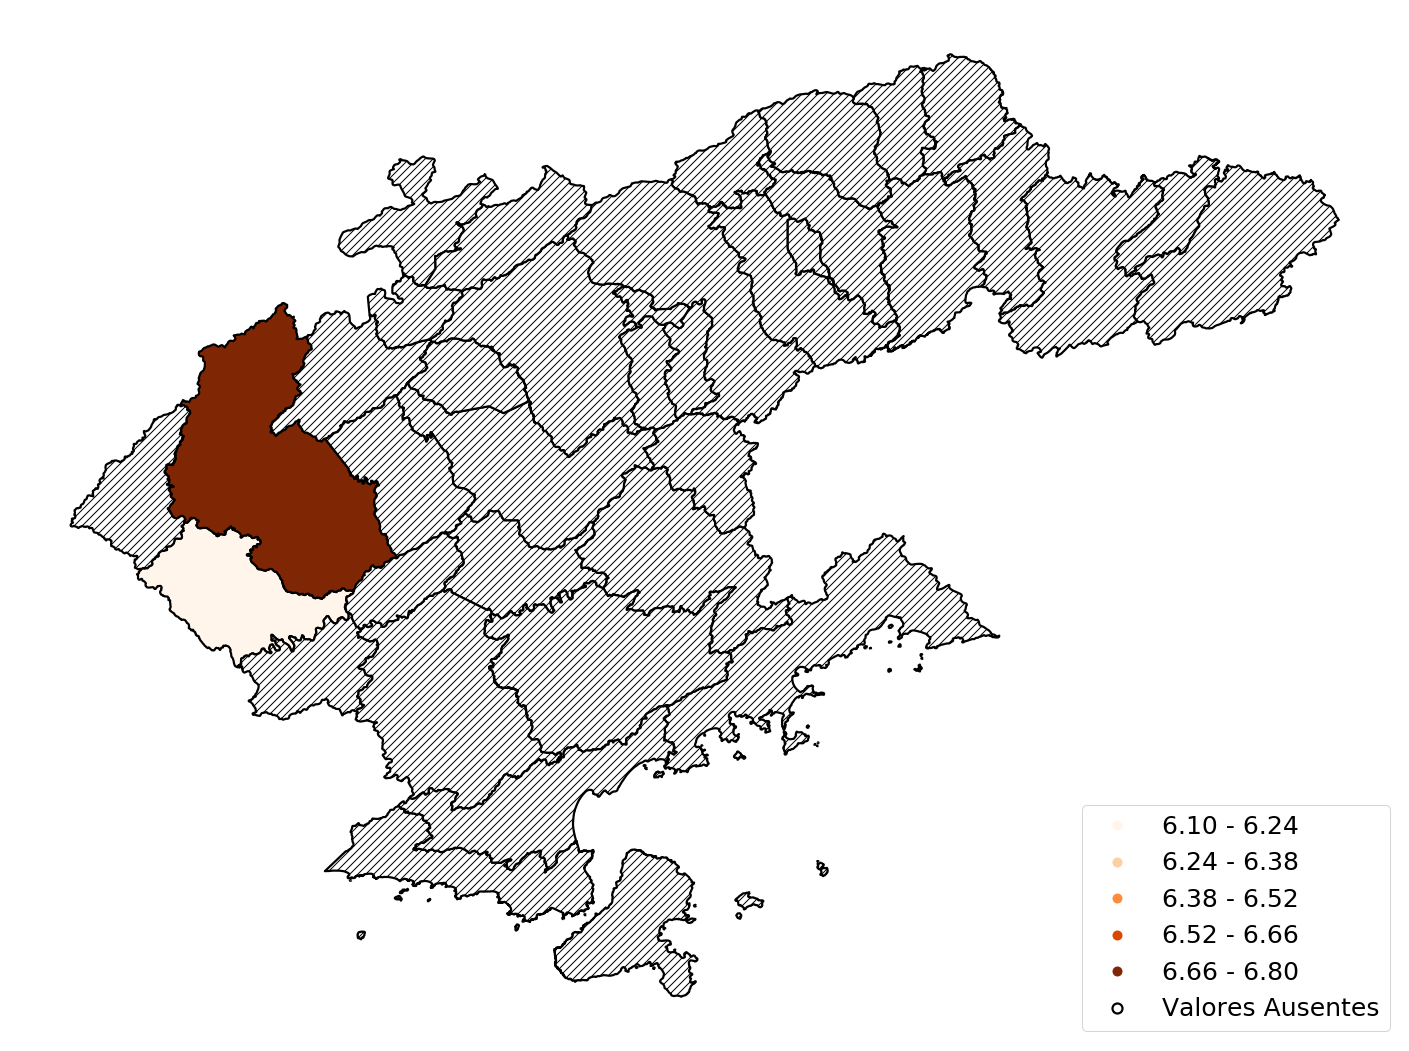

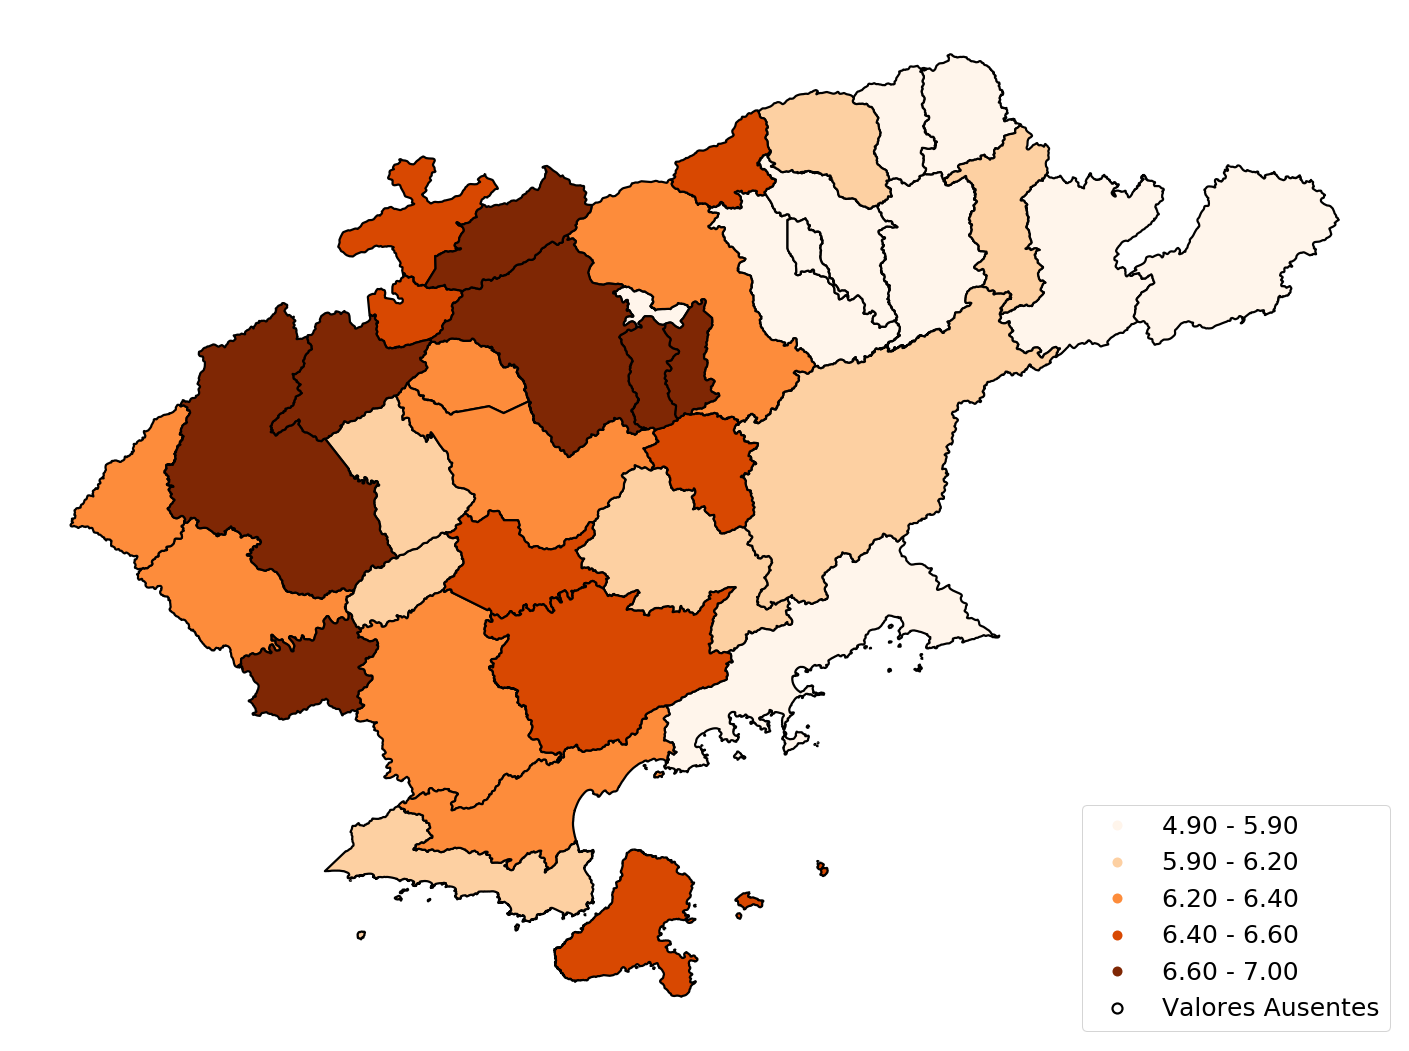

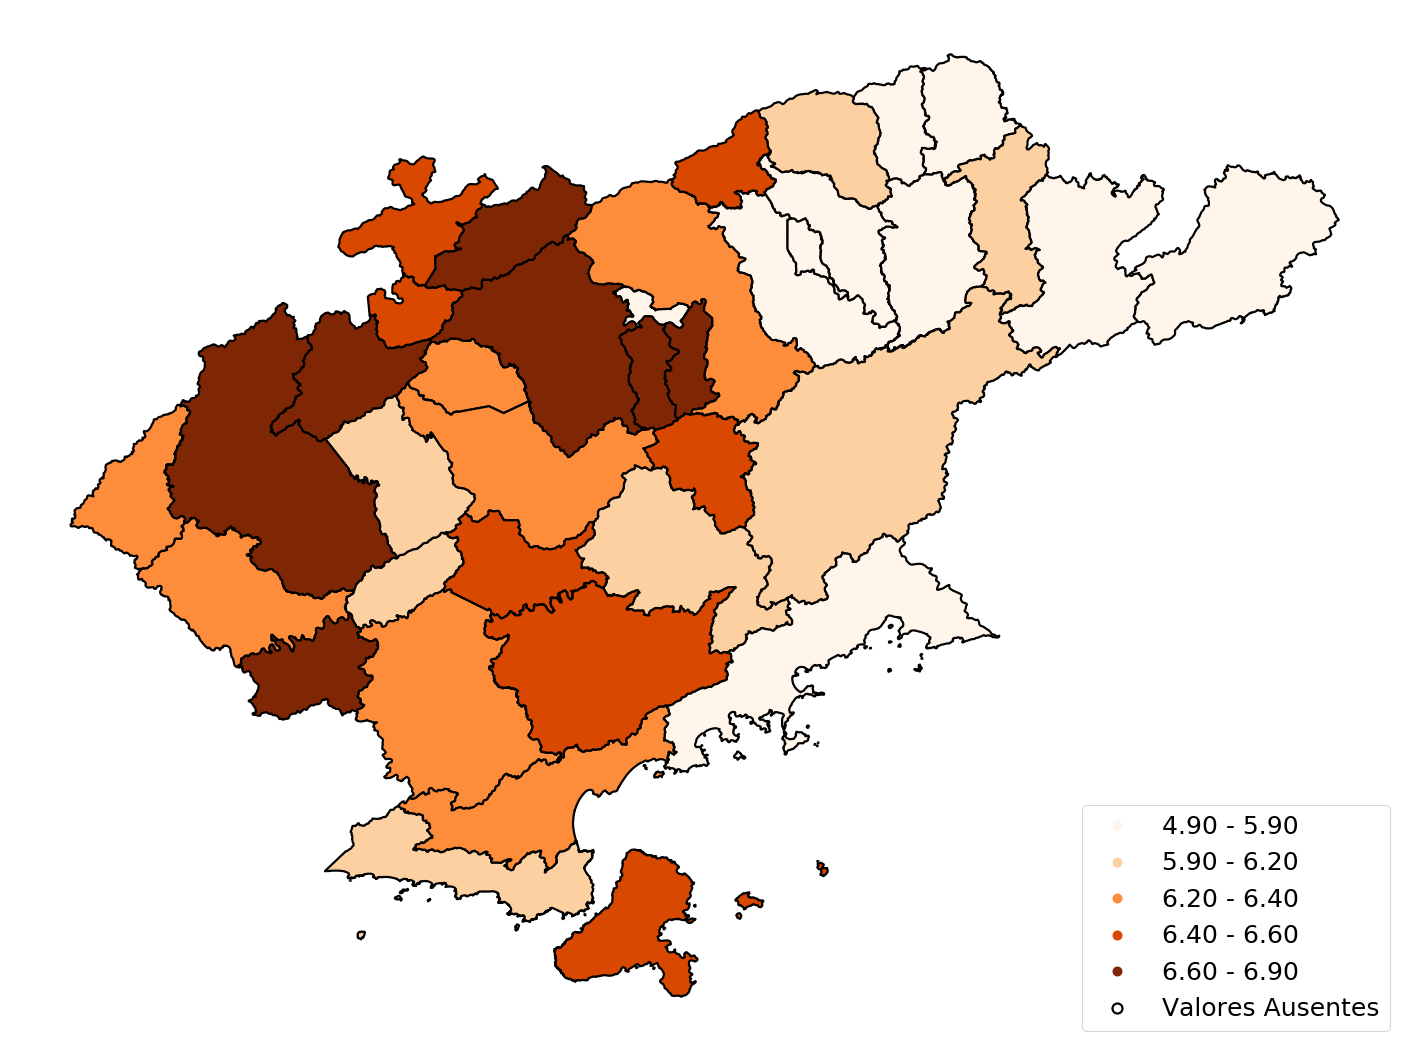

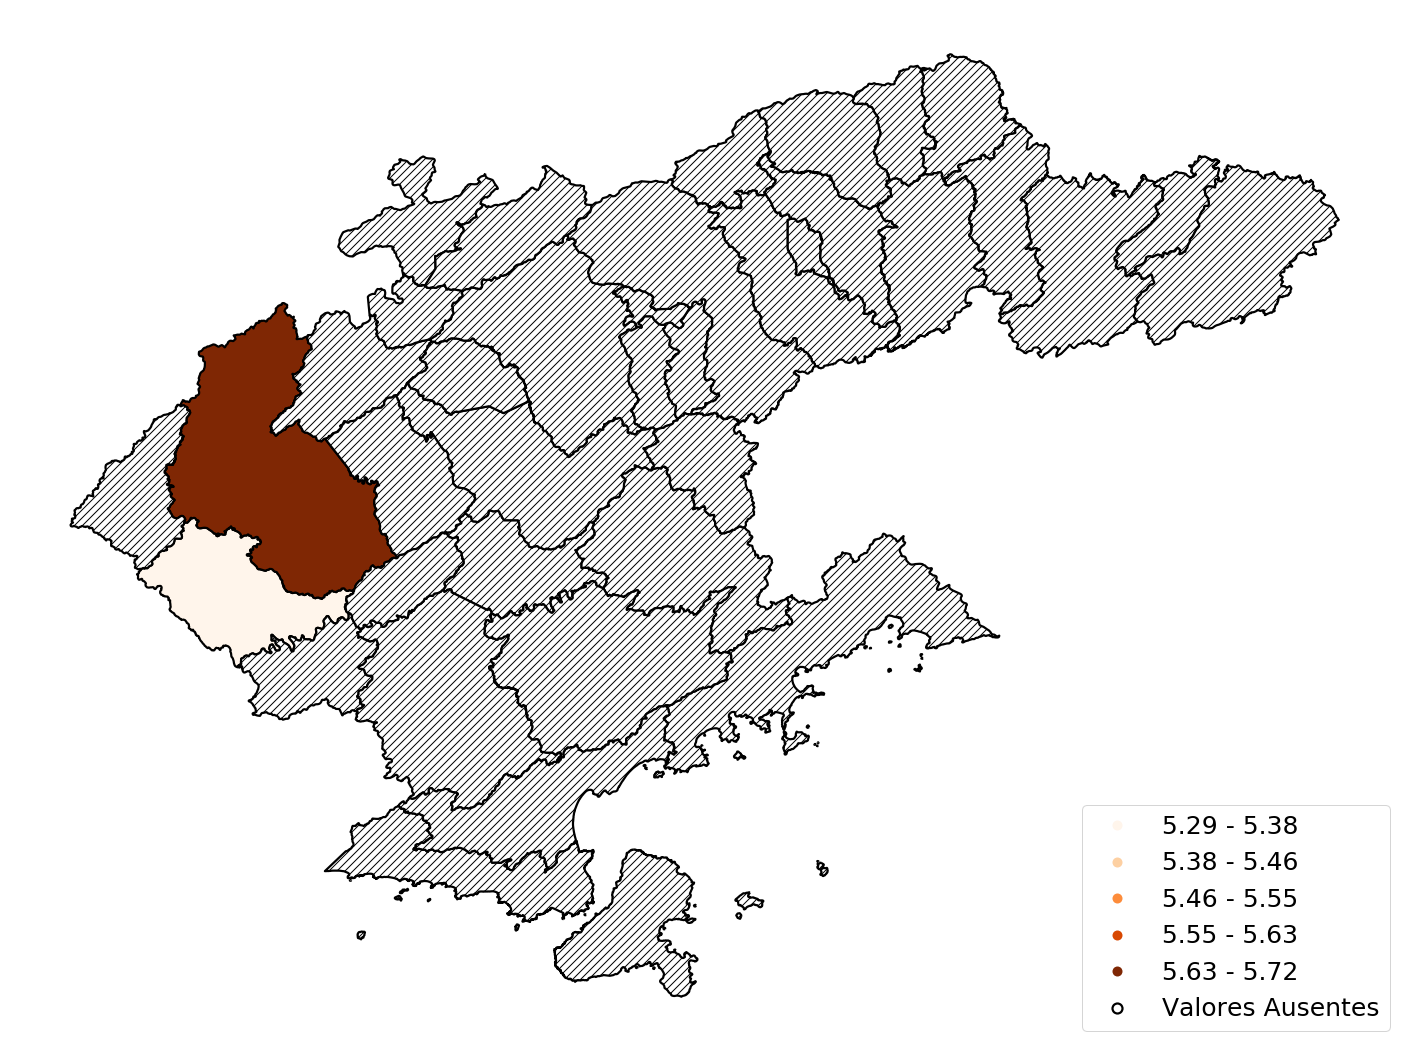

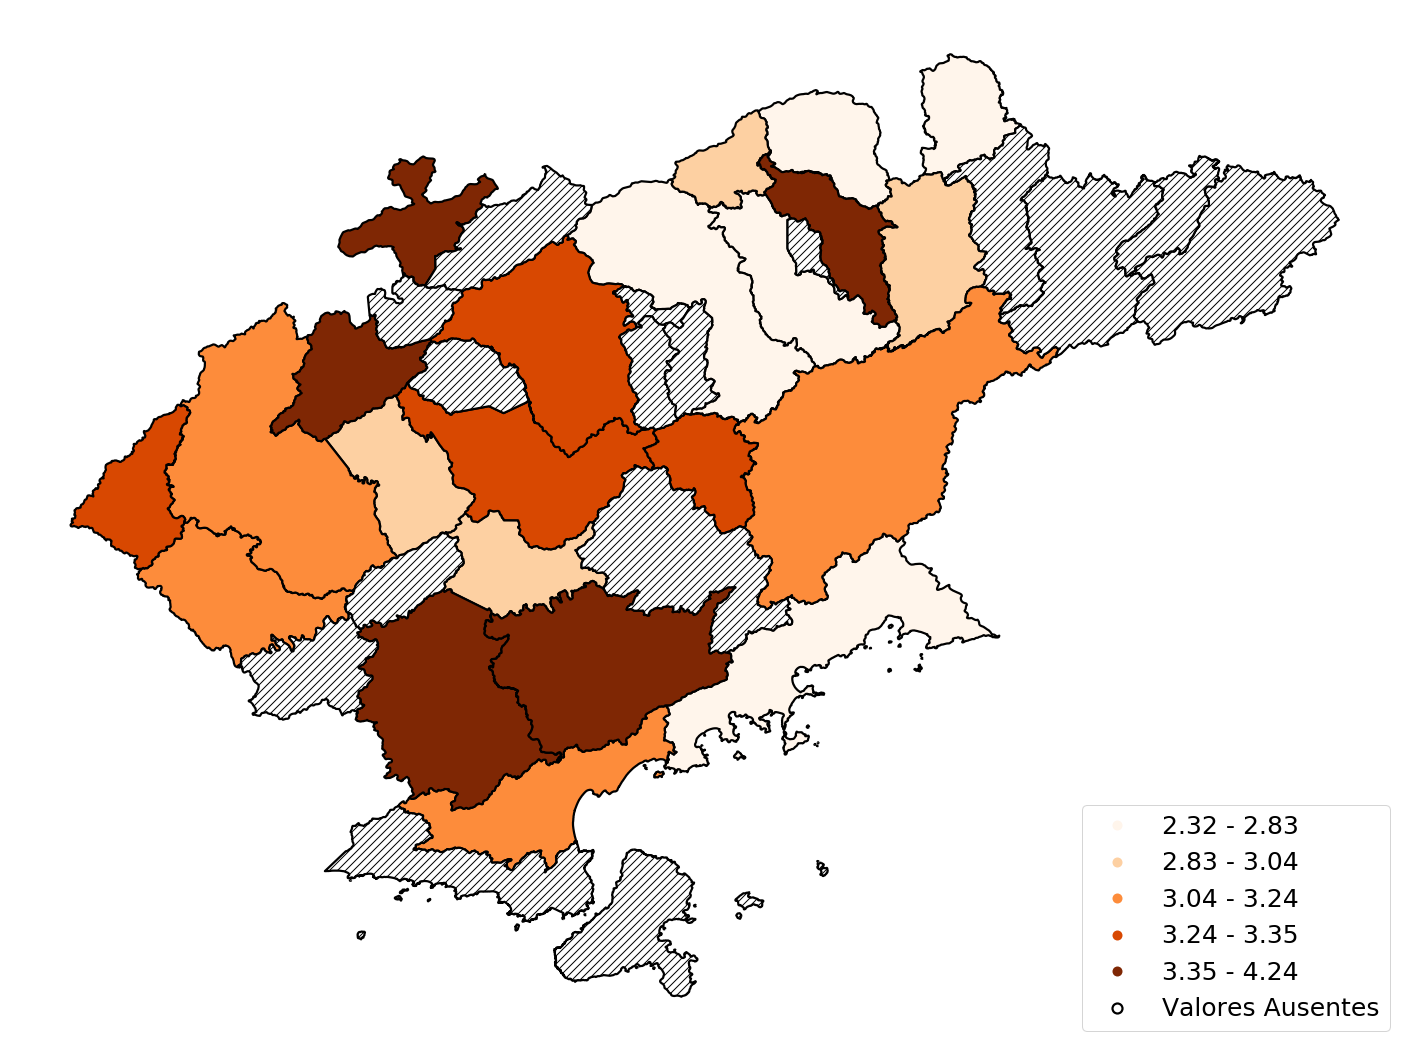

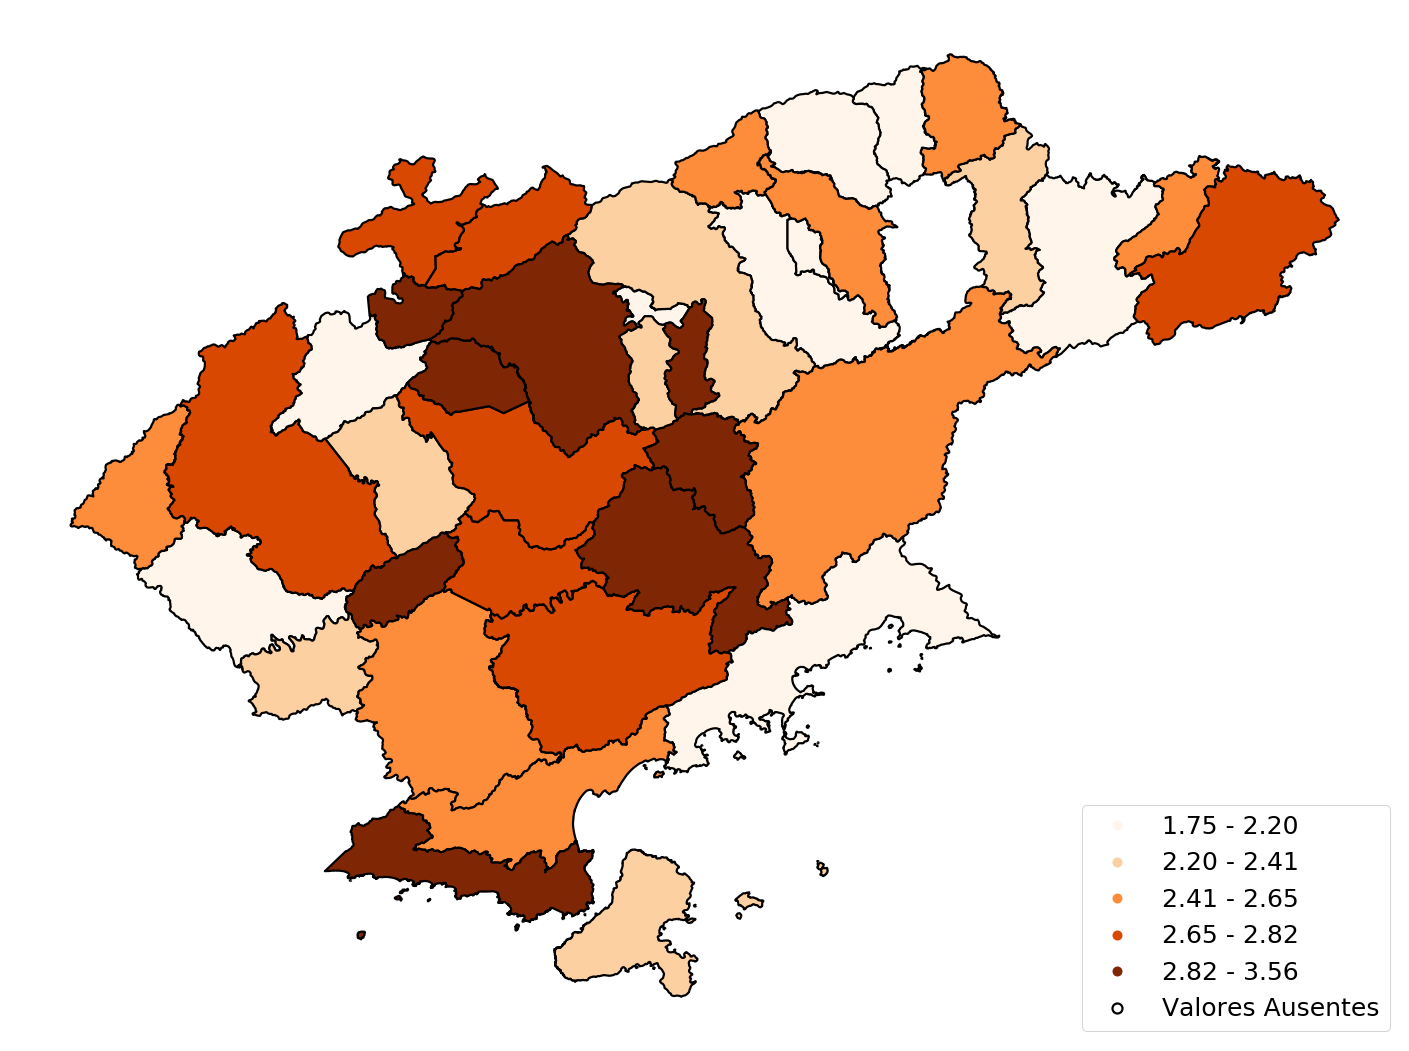

In [174]:
import yaml
themes = yaml.load(open('../themes/vale_themes.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['vale_bars']

var_file = {}

for var in variables:
    fig,df = plot_barss(dd,var,themes)
    ano = max(df['ano'])
    
    
    
    file_name = unidecode.unidecode(var.lower().replace(' ','_').replace('-',''))
    var_file[f'{var} ({ano})'] = file_name
    
    plot(fig, filename=f"../../sample_pages/pages/indicadores_vale/pages/educacao/images/bars/{file_name}.html", auto_open=False)
    
    
    
    fig_map = vis_graphs.plot_map(df,sp,var)
    fig_map.savefig(f"../../sample_pages/pages/indicadores_vale/pages/educacao/images/maps/{file_name}.png", bbox_inches='tight')

In [171]:
var_file

{'Concluintes do Ensino Fundamental (2013)': 'concluintes_do_ensino_fundamental',
 'Concluintes do Ensino Médio (2013)': 'concluintes_do_ensino_medio',
 'Matrículas na Creche (2019)': 'matriculas_na_creche',
 'Matrículas na Educação Infantil (2019)': 'matriculas_na_educacao_infantil',
 'Matrículas na Pré-escola (2019)': 'matriculas_na_preescola',
 'Matrículas no Ensino Fundamental (2019)': 'matriculas_no_ensino_fundamental',
 'Matrículas no Ensino Médio (2019)': 'matriculas_no_ensino_medio',
 'Meta do Índice de Desenvolvimento da Educação Básica (IDEB) - Ensino Fundamental - Anos Finais - Rede Estadual (2019)': 'meta_do_indice_de_desenvolvimento_da_educacao_basica_(ideb)__ensino_fundamental__anos_finais__rede_estadual',
 'Meta do Índice de Desenvolvimento da Educação Básica (IDEB) - Ensino Fundamental - Anos Finais - Rede Municipal (2019)': 'meta_do_indice_de_desenvolvimento_da_educacao_basica_(ideb)__ensino_fundamental__anos_finais__rede_municipal',
 'Meta do Índice de Desenvolvimento

In [172]:
for var in var_file.keys():
    print(f"<option value='{var_file[var]}'>{var}</option>")

<option value='concluintes_do_ensino_fundamental'>Concluintes do Ensino Fundamental (2013)</option>
<option value='concluintes_do_ensino_medio'>Concluintes do Ensino Médio (2013)</option>
<option value='matriculas_na_creche'>Matrículas na Creche (2019)</option>
<option value='matriculas_na_educacao_infantil'>Matrículas na Educação Infantil (2019)</option>
<option value='matriculas_na_preescola'>Matrículas na Pré-escola (2019)</option>
<option value='matriculas_no_ensino_fundamental'>Matrículas no Ensino Fundamental (2019)</option>
<option value='matriculas_no_ensino_medio'>Matrículas no Ensino Médio (2019)</option>
<option value='meta_do_indice_de_desenvolvimento_da_educacao_basica_(ideb)__ensino_fundamental__anos_finais__rede_estadual'>Meta do Índice de Desenvolvimento da Educação Básica (IDEB) - Ensino Fundamental - Anos Finais - Rede Estadual (2019)</option>
<option value='meta_do_indice_de_desenvolvimento_da_educacao_basica_(ideb)__ensino_fundamental__anos_finais__rede_municipal'>M

In [292]:


from lightning import Lightning

from numpy import random, zeros




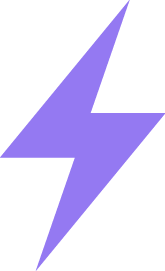

Problem connecting to server at http://public.lightning-viz.org
status code: 404


ValueError: Could not access server

In [293]:
lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')

In [294]:
from lightning import Lightning

lgn = Lightning(host="http://my-lightning-instance.herokuapp.com")

lgn.create_session()
lgn.create_session("provide an optional session name")

Lightning initialized
Problem connecting to server at http://my-lightning-instance.herokuapp.com
status code: 404


ValueError: Could not access server